In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2867343, 832)
(2867343, 8)
validation
(519557, 832)
(519557, 8)
test
(237229, 832)
(237229, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1543048 (5.89 MB)


Trainable params: 1543048 (5.89 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

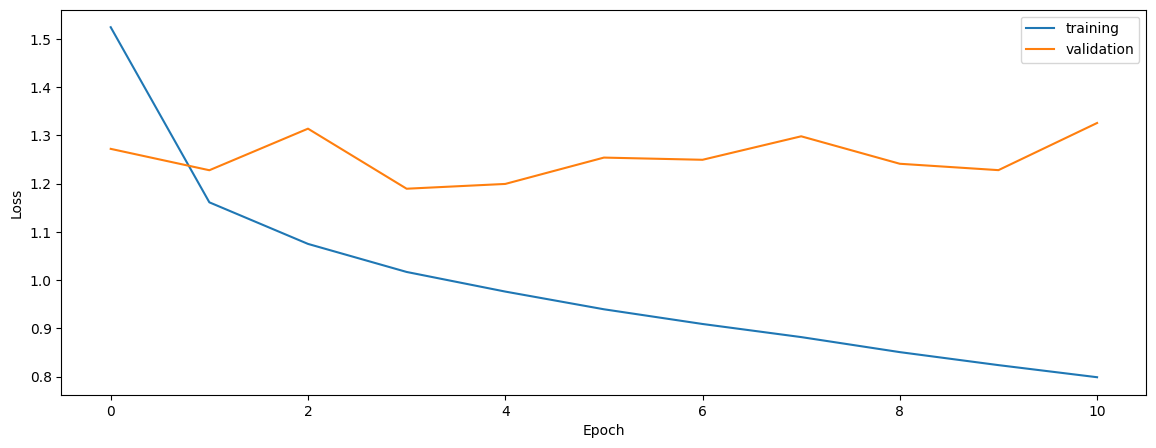

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(788651, 832)
(788651, 1)
validation
(140101, 832)
(140101, 1)
test
(66093, 832)
(66093, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 832)]             0         


 dense_5 (Dense)             (None, 1024)              852992    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1542145 (5.88 MB)


Trainable params: 1542145 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/79 [..............................] - ETA: 1:53 - loss: 0.2346 - STD: 2.9030e-04 - MAE: 0.4756

 4/79 [>.............................] - ETA: 1s - loss: 0.2296 - STD: 4.4521e-04 - MAE: 0.4350  

 7/79 [=>............................] - ETA: 1s - loss: 0.2262 - STD: 7.4905e-04 - MAE: 0.4437

10/79 [==>...........................] - ETA: 1s - loss: 0.2241 - STD: 0.0011 - MAE: 0.4462    

13/79 [===>..........................] - ETA: 1s - loss: 0.2231 - STD: 0.0015 - MAE: 0.4427

16/79 [=====>........................] - ETA: 1s - loss: 0.2218 - STD: 0.0019 - MAE: 0.4413

19/79 [======>.......................] - ETA: 1s - loss: 0.2210 - STD: 0.0024 - MAE: 0.4427

22/79 [=======>......................] - ETA: 1s - loss: 0.2203 - STD: 0.0031 - MAE: 0.4430

25/79 [========>.....................] - ETA: 1s - loss: 0.2196 - STD: 0.0039 - MAE: 0.4418

28/79 [=========>....................] - ETA: 1s - loss: 0.2188 - STD: 0.0052 - MAE: 0.4410

31/79 [==========>...................] - ETA: 1s - loss: 0.2180 - STD: 0.0072 - MAE: 0.4408

34/79 [===========>..................] - ETA: 1s - loss: 0.2169 - STD: 0.0103 - MAE: 0.4398

37/79 [=============>................] - ETA: 0s - loss: 0.2154 - STD: 0.0150 - MAE: 0.4378

38/79 [=============>................] - ETA: 1s - loss: 0.2148 - STD: 0.0172 - MAE: 0.4370

41/79 [==============>...............] - ETA: 1s - loss: 0.2129 - STD: 0.0252 - MAE: 0.4341

44/79 [===============>..............] - ETA: 1s - loss: 0.2111 - STD: 0.0349 - MAE: 0.4304

47/79 [================>.............] - ETA: 1s - loss: 0.2094 - STD: 0.0450 - MAE: 0.4265

50/79 [=================>............] - ETA: 1s - loss: 0.2078 - STD: 0.0536 - MAE: 0.4232

53/79 [===================>..........] - ETA: 1s - loss: 0.2064 - STD: 0.0599 - MAE: 0.4208

56/79 [====================>.........] - ETA: 0s - loss: 0.2052 - STD: 0.0653 - MAE: 0.4188

59/79 [=====================>........] - ETA: 0s - loss: 0.2039 - STD: 0.0708 - MAE: 0.4165

62/79 [======================>.......] - ETA: 0s - loss: 0.2026 - STD: 0.0770 - MAE: 0.4138

65/79 [=======================>......] - ETA: 0s - loss: 0.2015 - STD: 0.0829 - MAE: 0.4114

68/79 [========================>.....] - ETA: 0s - loss: 0.2004 - STD: 0.0878 - MAE: 0.4093

71/79 [=========================>....] - ETA: 0s - loss: 0.1993 - STD: 0.0918 - MAE: 0.4076

74/79 [===========================>..] - ETA: 0s - loss: 0.1983 - STD: 0.0958 - MAE: 0.4058

77/79 [============================>.] - ETA: 0s - loss: 0.1973 - STD: 0.1000 - MAE: 0.4039

79/79 [==============================] - 5s 43ms/step - loss: 0.1967 - STD: 0.1028 - MAE: 0.4027 - val_loss: 0.1750 - val_STD: 0.1528 - val_MAE: 0.3552


Epoch 2/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1723 - STD: 0.2067 - MAE: 0.3530

 4/79 [>.............................] - ETA: 1s - loss: 0.1696 - STD: 0.2058 - MAE: 0.3526

 7/79 [=>............................] - ETA: 1s - loss: 0.1687 - STD: 0.2073 - MAE: 0.3515

10/79 [==>...........................] - ETA: 1s - loss: 0.1680 - STD: 0.2100 - MAE: 0.3498

13/79 [===>..........................] - ETA: 1s - loss: 0.1675 - STD: 0.2133 - MAE: 0.3485

16/79 [=====>........................] - ETA: 1s - loss: 0.1672 - STD: 0.2155 - MAE: 0.3473

19/79 [======>.......................] - ETA: 1s - loss: 0.1666 - STD: 0.2169 - MAE: 0.3458

22/79 [=======>......................] - ETA: 1s - loss: 0.1662 - STD: 0.2184 - MAE: 0.3450

25/79 [========>.....................] - ETA: 1s - loss: 0.1658 - STD: 0.2197 - MAE: 0.3442

28/79 [=========>....................] - ETA: 1s - loss: 0.1651 - STD: 0.2204 - MAE: 0.3433

31/79 [==========>...................] - ETA: 1s - loss: 0.1649 - STD: 0.2211 - MAE: 0.3428

34/79 [===========>..................] - ETA: 1s - loss: 0.1647 - STD: 0.2219 - MAE: 0.3423

37/79 [=============>................] - ETA: 0s - loss: 0.1645 - STD: 0.2225 - MAE: 0.3418

40/79 [==============>...............] - ETA: 0s - loss: 0.1643 - STD: 0.2230 - MAE: 0.3413

43/79 [===============>..............] - ETA: 0s - loss: 0.1640 - STD: 0.2232 - MAE: 0.3409

46/79 [================>.............] - ETA: 0s - loss: 0.1640 - STD: 0.2235 - MAE: 0.3407

49/79 [=================>............] - ETA: 0s - loss: 0.1639 - STD: 0.2239 - MAE: 0.3403

52/79 [==================>...........] - ETA: 0s - loss: 0.1638 - STD: 0.2245 - MAE: 0.3402

55/79 [===================>..........] - ETA: 0s - loss: 0.1637 - STD: 0.2249 - MAE: 0.3399

58/79 [=====================>........] - ETA: 0s - loss: 0.1634 - STD: 0.2251 - MAE: 0.3396

61/79 [======================>.......] - ETA: 0s - loss: 0.1633 - STD: 0.2255 - MAE: 0.3393

64/79 [=======================>......] - ETA: 0s - loss: 0.1632 - STD: 0.2260 - MAE: 0.3391

67/79 [========================>.....] - ETA: 0s - loss: 0.1631 - STD: 0.2265 - MAE: 0.3388

70/79 [=========================>....] - ETA: 0s - loss: 0.1631 - STD: 0.2269 - MAE: 0.3387

73/79 [==========================>...] - ETA: 0s - loss: 0.1630 - STD: 0.2270 - MAE: 0.3384

76/79 [===========================>..] - ETA: 0s - loss: 0.1630 - STD: 0.2271 - MAE: 0.3383

79/79 [==============================] - ETA: 0s - loss: 0.1629 - STD: 0.2273 - MAE: 0.3382

79/79 [==============================] - 2s 26ms/step - loss: 0.1629 - STD: 0.2273 - MAE: 0.3382 - val_loss: 0.1713 - val_STD: 0.1656 - val_MAE: 0.3374


Epoch 3/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1614 - STD: 0.2195 - MAE: 0.3316

 4/79 [>.............................] - ETA: 1s - loss: 0.1598 - STD: 0.2312 - MAE: 0.3334

 7/79 [=>............................] - ETA: 1s - loss: 0.1593 - STD: 0.2309 - MAE: 0.3324

10/79 [==>...........................] - ETA: 1s - loss: 0.1598 - STD: 0.2321 - MAE: 0.3327

13/79 [===>..........................] - ETA: 1s - loss: 0.1597 - STD: 0.2329 - MAE: 0.3324

16/79 [=====>........................] - ETA: 1s - loss: 0.1595 - STD: 0.2339 - MAE: 0.3321

19/79 [======>.......................] - ETA: 1s - loss: 0.1598 - STD: 0.2339 - MAE: 0.3322

22/79 [=======>......................] - ETA: 1s - loss: 0.1598 - STD: 0.2338 - MAE: 0.3321

25/79 [========>.....................] - ETA: 1s - loss: 0.1599 - STD: 0.2342 - MAE: 0.3322

28/79 [=========>....................] - ETA: 1s - loss: 0.1598 - STD: 0.2345 - MAE: 0.3322

31/79 [==========>...................] - ETA: 1s - loss: 0.1597 - STD: 0.2347 - MAE: 0.3320

34/79 [===========>..................] - ETA: 1s - loss: 0.1597 - STD: 0.2351 - MAE: 0.3320

37/79 [=============>................] - ETA: 0s - loss: 0.1595 - STD: 0.2353 - MAE: 0.3318

40/79 [==============>...............] - ETA: 0s - loss: 0.1596 - STD: 0.2355 - MAE: 0.3318

43/79 [===============>..............] - ETA: 0s - loss: 0.1594 - STD: 0.2358 - MAE: 0.3315

46/79 [================>.............] - ETA: 0s - loss: 0.1594 - STD: 0.2360 - MAE: 0.3315

49/79 [=================>............] - ETA: 0s - loss: 0.1595 - STD: 0.2360 - MAE: 0.3315

52/79 [==================>...........] - ETA: 0s - loss: 0.1595 - STD: 0.2361 - MAE: 0.3315

55/79 [===================>..........] - ETA: 0s - loss: 0.1596 - STD: 0.2362 - MAE: 0.3315

58/79 [=====================>........] - ETA: 0s - loss: 0.1595 - STD: 0.2362 - MAE: 0.3315

61/79 [======================>.......] - ETA: 0s - loss: 0.1596 - STD: 0.2362 - MAE: 0.3317

64/79 [=======================>......] - ETA: 0s - loss: 0.1596 - STD: 0.2362 - MAE: 0.3317

67/79 [========================>.....] - ETA: 0s - loss: 0.1595 - STD: 0.2363 - MAE: 0.3315

70/79 [=========================>....] - ETA: 0s - loss: 0.1594 - STD: 0.2365 - MAE: 0.3314

73/79 [==========================>...] - ETA: 0s - loss: 0.1593 - STD: 0.2367 - MAE: 0.3312

76/79 [===========================>..] - ETA: 0s - loss: 0.1593 - STD: 0.2367 - MAE: 0.3311

79/79 [==============================] - ETA: 0s - loss: 0.1593 - STD: 0.2369 - MAE: 0.3310

79/79 [==============================] - 2s 26ms/step - loss: 0.1593 - STD: 0.2369 - MAE: 0.3310 - val_loss: 0.1649 - val_STD: 0.1919 - val_MAE: 0.3355


Epoch 4/10000


 1/79 [..............................] - ETA: 4s - loss: 0.1605 - STD: 0.2428 - MAE: 0.3322

 4/79 [>.............................] - ETA: 1s - loss: 0.1593 - STD: 0.2413 - MAE: 0.3308

 7/79 [=>............................] - ETA: 1s - loss: 0.1586 - STD: 0.2393 - MAE: 0.3299

10/79 [==>...........................] - ETA: 1s - loss: 0.1587 - STD: 0.2384 - MAE: 0.3300

13/79 [===>..........................] - ETA: 1s - loss: 0.1584 - STD: 0.2388 - MAE: 0.3297

16/79 [=====>........................] - ETA: 1s - loss: 0.1585 - STD: 0.2393 - MAE: 0.3297

19/79 [======>.......................] - ETA: 1s - loss: 0.1586 - STD: 0.2399 - MAE: 0.3295

22/79 [=======>......................] - ETA: 1s - loss: 0.1584 - STD: 0.2399 - MAE: 0.3293

25/79 [========>.....................] - ETA: 1s - loss: 0.1584 - STD: 0.2398 - MAE: 0.3293

28/79 [=========>....................] - ETA: 1s - loss: 0.1583 - STD: 0.2399 - MAE: 0.3292

31/79 [==========>...................] - ETA: 1s - loss: 0.1581 - STD: 0.2400 - MAE: 0.3288

34/79 [===========>..................] - ETA: 1s - loss: 0.1582 - STD: 0.2401 - MAE: 0.3286

37/79 [=============>................] - ETA: 0s - loss: 0.1584 - STD: 0.2401 - MAE: 0.3287

40/79 [==============>...............] - ETA: 0s - loss: 0.1584 - STD: 0.2401 - MAE: 0.3288

43/79 [===============>..............] - ETA: 0s - loss: 0.1582 - STD: 0.2399 - MAE: 0.3287

46/79 [================>.............] - ETA: 0s - loss: 0.1582 - STD: 0.2398 - MAE: 0.3287

49/79 [=================>............] - ETA: 0s - loss: 0.1583 - STD: 0.2400 - MAE: 0.3287

52/79 [==================>...........] - ETA: 0s - loss: 0.1584 - STD: 0.2401 - MAE: 0.3287

55/79 [===================>..........] - ETA: 0s - loss: 0.1584 - STD: 0.2401 - MAE: 0.3287

58/79 [=====================>........] - ETA: 0s - loss: 0.1583 - STD: 0.2400 - MAE: 0.3286

61/79 [======================>.......] - ETA: 0s - loss: 0.1582 - STD: 0.2400 - MAE: 0.3286

64/79 [=======================>......] - ETA: 0s - loss: 0.1581 - STD: 0.2401 - MAE: 0.3285

67/79 [========================>.....] - ETA: 0s - loss: 0.1581 - STD: 0.2404 - MAE: 0.3283

70/79 [=========================>....] - ETA: 0s - loss: 0.1580 - STD: 0.2405 - MAE: 0.3282

73/79 [==========================>...] - ETA: 0s - loss: 0.1580 - STD: 0.2406 - MAE: 0.3282

76/79 [===========================>..] - ETA: 0s - loss: 0.1581 - STD: 0.2407 - MAE: 0.3282

79/79 [==============================] - ETA: 0s - loss: 0.1580 - STD: 0.2407 - MAE: 0.3281

79/79 [==============================] - 2s 26ms/step - loss: 0.1580 - STD: 0.2407 - MAE: 0.3281 - val_loss: 0.1633 - val_STD: 0.1882 - val_MAE: 0.3317


Epoch 5/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1575 - STD: 0.2431 - MAE: 0.3280

 4/79 [>.............................] - ETA: 1s - loss: 0.1564 - STD: 0.2414 - MAE: 0.3261

 7/79 [=>............................] - ETA: 1s - loss: 0.1565 - STD: 0.2424 - MAE: 0.3265

10/79 [==>...........................] - ETA: 1s - loss: 0.1567 - STD: 0.2427 - MAE: 0.3267

13/79 [===>..........................] - ETA: 1s - loss: 0.1568 - STD: 0.2427 - MAE: 0.3267

16/79 [=====>........................] - ETA: 1s - loss: 0.1568 - STD: 0.2431 - MAE: 0.3265

19/79 [======>.......................] - ETA: 1s - loss: 0.1568 - STD: 0.2438 - MAE: 0.3262

22/79 [=======>......................] - ETA: 1s - loss: 0.1567 - STD: 0.2438 - MAE: 0.3259

25/79 [========>.....................] - ETA: 1s - loss: 0.1566 - STD: 0.2436 - MAE: 0.3257

28/79 [=========>....................] - ETA: 1s - loss: 0.1566 - STD: 0.2437 - MAE: 0.3257

31/79 [==========>...................] - ETA: 1s - loss: 0.1568 - STD: 0.2437 - MAE: 0.3259

34/79 [===========>..................] - ETA: 1s - loss: 0.1569 - STD: 0.2431 - MAE: 0.3261

37/79 [=============>................] - ETA: 0s - loss: 0.1569 - STD: 0.2428 - MAE: 0.3262

40/79 [==============>...............] - ETA: 0s - loss: 0.1568 - STD: 0.2428 - MAE: 0.3262

43/79 [===============>..............] - ETA: 0s - loss: 0.1569 - STD: 0.2429 - MAE: 0.3261

46/79 [================>.............] - ETA: 0s - loss: 0.1569 - STD: 0.2431 - MAE: 0.3259

49/79 [=================>............] - ETA: 0s - loss: 0.1571 - STD: 0.2432 - MAE: 0.3260

52/79 [==================>...........] - ETA: 0s - loss: 0.1570 - STD: 0.2430 - MAE: 0.3260

55/79 [===================>..........] - ETA: 0s - loss: 0.1569 - STD: 0.2426 - MAE: 0.3261

58/79 [=====================>........] - ETA: 0s - loss: 0.1570 - STD: 0.2426 - MAE: 0.3262

61/79 [======================>.......] - ETA: 0s - loss: 0.1569 - STD: 0.2426 - MAE: 0.3261

64/79 [=======================>......] - ETA: 0s - loss: 0.1568 - STD: 0.2428 - MAE: 0.3259

67/79 [========================>.....] - ETA: 0s - loss: 0.1568 - STD: 0.2429 - MAE: 0.3259

70/79 [=========================>....] - ETA: 0s - loss: 0.1569 - STD: 0.2430 - MAE: 0.3259

73/79 [==========================>...] - ETA: 0s - loss: 0.1568 - STD: 0.2431 - MAE: 0.3257

76/79 [===========================>..] - ETA: 0s - loss: 0.1570 - STD: 0.2431 - MAE: 0.3259

79/79 [==============================] - ETA: 0s - loss: 0.1570 - STD: 0.2430 - MAE: 0.3259

79/79 [==============================] - 2s 26ms/step - loss: 0.1570 - STD: 0.2430 - MAE: 0.3259 - val_loss: 0.1610 - val_STD: 0.1912 - val_MAE: 0.3322


Epoch 6/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1564 - STD: 0.2414 - MAE: 0.3295

 4/79 [>.............................] - ETA: 1s - loss: 0.1574 - STD: 0.2362 - MAE: 0.3294

 7/79 [=>............................] - ETA: 1s - loss: 0.1574 - STD: 0.2368 - MAE: 0.3292

10/79 [==>...........................] - ETA: 1s - loss: 0.1570 - STD: 0.2390 - MAE: 0.3283

13/79 [===>..........................] - ETA: 1s - loss: 0.1564 - STD: 0.2409 - MAE: 0.3270

16/79 [=====>........................] - ETA: 1s - loss: 0.1564 - STD: 0.2427 - MAE: 0.3261

19/79 [======>.......................] - ETA: 1s - loss: 0.1565 - STD: 0.2437 - MAE: 0.3256

22/79 [=======>......................] - ETA: 1s - loss: 0.1565 - STD: 0.2436 - MAE: 0.3254

25/79 [========>.....................] - ETA: 1s - loss: 0.1563 - STD: 0.2435 - MAE: 0.3252

28/79 [=========>....................] - ETA: 1s - loss: 0.1563 - STD: 0.2437 - MAE: 0.3251

31/79 [==========>...................] - ETA: 1s - loss: 0.1561 - STD: 0.2438 - MAE: 0.3249

34/79 [===========>..................] - ETA: 1s - loss: 0.1562 - STD: 0.2438 - MAE: 0.3249

37/79 [=============>................] - ETA: 0s - loss: 0.1560 - STD: 0.2440 - MAE: 0.3247

40/79 [==============>...............] - ETA: 0s - loss: 0.1560 - STD: 0.2441 - MAE: 0.3247

43/79 [===============>..............] - ETA: 0s - loss: 0.1560 - STD: 0.2443 - MAE: 0.3246

46/79 [================>.............] - ETA: 0s - loss: 0.1559 - STD: 0.2445 - MAE: 0.3244

49/79 [=================>............] - ETA: 0s - loss: 0.1558 - STD: 0.2447 - MAE: 0.3242

52/79 [==================>...........] - ETA: 0s - loss: 0.1558 - STD: 0.2447 - MAE: 0.3241

55/79 [===================>..........] - ETA: 0s - loss: 0.1559 - STD: 0.2447 - MAE: 0.3242

58/79 [=====================>........] - ETA: 0s - loss: 0.1559 - STD: 0.2447 - MAE: 0.3241

61/79 [======================>.......] - ETA: 0s - loss: 0.1559 - STD: 0.2445 - MAE: 0.3242

64/79 [=======================>......] - ETA: 0s - loss: 0.1559 - STD: 0.2447 - MAE: 0.3242

67/79 [========================>.....] - ETA: 0s - loss: 0.1559 - STD: 0.2447 - MAE: 0.3241

70/79 [=========================>....] - ETA: 0s - loss: 0.1559 - STD: 0.2448 - MAE: 0.3241

73/79 [==========================>...] - ETA: 0s - loss: 0.1558 - STD: 0.2447 - MAE: 0.3240

76/79 [===========================>..] - ETA: 0s - loss: 0.1558 - STD: 0.2445 - MAE: 0.3240

79/79 [==============================] - ETA: 0s - loss: 0.1557 - STD: 0.2447 - MAE: 0.3239

79/79 [==============================] - 2s 26ms/step - loss: 0.1557 - STD: 0.2447 - MAE: 0.3239 - val_loss: 0.1604 - val_STD: 0.2012 - val_MAE: 0.3225


Epoch 7/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1508 - STD: 0.2521 - MAE: 0.3167

 4/79 [>.............................] - ETA: 1s - loss: 0.1538 - STD: 0.2549 - MAE: 0.3180

 7/79 [=>............................] - ETA: 1s - loss: 0.1538 - STD: 0.2552 - MAE: 0.3178

10/79 [==>...........................] - ETA: 1s - loss: 0.1535 - STD: 0.2532 - MAE: 0.3183

13/79 [===>..........................] - ETA: 1s - loss: 0.1539 - STD: 0.2515 - MAE: 0.3193

16/79 [=====>........................] - ETA: 1s - loss: 0.1547 - STD: 0.2500 - MAE: 0.3207

19/79 [======>.......................] - ETA: 1s - loss: 0.1556 - STD: 0.2485 - MAE: 0.3219

22/79 [=======>......................] - ETA: 1s - loss: 0.1563 - STD: 0.2470 - MAE: 0.3226

25/79 [========>.....................] - ETA: 1s - loss: 0.1562 - STD: 0.2461 - MAE: 0.3225

28/79 [=========>....................] - ETA: 1s - loss: 0.1563 - STD: 0.2450 - MAE: 0.3230

31/79 [==========>...................] - ETA: 1s - loss: 0.1561 - STD: 0.2444 - MAE: 0.3234

34/79 [===========>..................] - ETA: 1s - loss: 0.1562 - STD: 0.2442 - MAE: 0.3238

37/79 [=============>................] - ETA: 0s - loss: 0.1564 - STD: 0.2440 - MAE: 0.3241

40/79 [==============>...............] - ETA: 0s - loss: 0.1564 - STD: 0.2437 - MAE: 0.3240

43/79 [===============>..............] - ETA: 0s - loss: 0.1564 - STD: 0.2440 - MAE: 0.3238

46/79 [================>.............] - ETA: 0s - loss: 0.1564 - STD: 0.2443 - MAE: 0.3236

49/79 [=================>............] - ETA: 0s - loss: 0.1564 - STD: 0.2449 - MAE: 0.3236

52/79 [==================>...........] - ETA: 0s - loss: 0.1563 - STD: 0.2447 - MAE: 0.3236

55/79 [===================>..........] - ETA: 0s - loss: 0.1563 - STD: 0.2444 - MAE: 0.3236

58/79 [=====================>........] - ETA: 0s - loss: 0.1562 - STD: 0.2442 - MAE: 0.3236

61/79 [======================>.......] - ETA: 0s - loss: 0.1560 - STD: 0.2444 - MAE: 0.3234

64/79 [=======================>......] - ETA: 0s - loss: 0.1559 - STD: 0.2447 - MAE: 0.3232

67/79 [========================>.....] - ETA: 0s - loss: 0.1558 - STD: 0.2451 - MAE: 0.3230

70/79 [=========================>....] - ETA: 0s - loss: 0.1558 - STD: 0.2454 - MAE: 0.3229

73/79 [==========================>...] - ETA: 0s - loss: 0.1557 - STD: 0.2456 - MAE: 0.3227

76/79 [===========================>..] - ETA: 0s - loss: 0.1556 - STD: 0.2457 - MAE: 0.3226

79/79 [==============================] - ETA: 0s - loss: 0.1556 - STD: 0.2456 - MAE: 0.3226

79/79 [==============================] - 2s 26ms/step - loss: 0.1556 - STD: 0.2456 - MAE: 0.3226 - val_loss: 0.1592 - val_STD: 0.2108 - val_MAE: 0.3284


Epoch 8/10000


 1/79 [..............................] - ETA: 4s - loss: 0.1563 - STD: 0.2543 - MAE: 0.3271

 4/79 [>.............................] - ETA: 1s - loss: 0.1531 - STD: 0.2470 - MAE: 0.3197

 7/79 [=>............................] - ETA: 1s - loss: 0.1553 - STD: 0.2451 - MAE: 0.3213

10/79 [==>...........................] - ETA: 1s - loss: 0.1559 - STD: 0.2454 - MAE: 0.3224

13/79 [===>..........................] - ETA: 1s - loss: 0.1558 - STD: 0.2454 - MAE: 0.3228

16/79 [=====>........................] - ETA: 1s - loss: 0.1555 - STD: 0.2443 - MAE: 0.3229

19/79 [======>.......................] - ETA: 1s - loss: 0.1551 - STD: 0.2437 - MAE: 0.3225

22/79 [=======>......................] - ETA: 1s - loss: 0.1549 - STD: 0.2443 - MAE: 0.3222

25/79 [========>.....................] - ETA: 1s - loss: 0.1547 - STD: 0.2453 - MAE: 0.3218

28/79 [=========>....................] - ETA: 1s - loss: 0.1547 - STD: 0.2462 - MAE: 0.3216

31/79 [==========>...................] - ETA: 1s - loss: 0.1547 - STD: 0.2466 - MAE: 0.3213

34/79 [===========>..................] - ETA: 1s - loss: 0.1547 - STD: 0.2468 - MAE: 0.3212

37/79 [=============>................] - ETA: 0s - loss: 0.1546 - STD: 0.2468 - MAE: 0.3211

40/79 [==============>...............] - ETA: 0s - loss: 0.1547 - STD: 0.2468 - MAE: 0.3213

43/79 [===============>..............] - ETA: 0s - loss: 0.1545 - STD: 0.2470 - MAE: 0.3211

46/79 [================>.............] - ETA: 0s - loss: 0.1544 - STD: 0.2472 - MAE: 0.3210

49/79 [=================>............] - ETA: 0s - loss: 0.1544 - STD: 0.2474 - MAE: 0.3211

52/79 [==================>...........] - ETA: 0s - loss: 0.1543 - STD: 0.2475 - MAE: 0.3208

55/79 [===================>..........] - ETA: 0s - loss: 0.1543 - STD: 0.2477 - MAE: 0.3208

58/79 [=====================>........] - ETA: 0s - loss: 0.1543 - STD: 0.2479 - MAE: 0.3207

61/79 [======================>.......] - ETA: 0s - loss: 0.1542 - STD: 0.2480 - MAE: 0.3207

64/79 [=======================>......] - ETA: 0s - loss: 0.1541 - STD: 0.2481 - MAE: 0.3206

67/79 [========================>.....] - ETA: 0s - loss: 0.1541 - STD: 0.2483 - MAE: 0.3204

70/79 [=========================>....] - ETA: 0s - loss: 0.1541 - STD: 0.2483 - MAE: 0.3204

73/79 [==========================>...] - ETA: 0s - loss: 0.1539 - STD: 0.2485 - MAE: 0.3202

76/79 [===========================>..] - ETA: 0s - loss: 0.1538 - STD: 0.2488 - MAE: 0.3201

79/79 [==============================] - ETA: 0s - loss: 0.1538 - STD: 0.2490 - MAE: 0.3200

79/79 [==============================] - 2s 26ms/step - loss: 0.1538 - STD: 0.2490 - MAE: 0.3200 - val_loss: 0.1620 - val_STD: 0.1939 - val_MAE: 0.3160


Epoch 9/10000


 1/79 [..............................] - ETA: 4s - loss: 0.1530 - STD: 0.2471 - MAE: 0.3138

 4/79 [>.............................] - ETA: 1s - loss: 0.1539 - STD: 0.2513 - MAE: 0.3171

 7/79 [=>............................] - ETA: 1s - loss: 0.1529 - STD: 0.2507 - MAE: 0.3173

10/79 [==>...........................] - ETA: 1s - loss: 0.1526 - STD: 0.2502 - MAE: 0.3180

13/79 [===>..........................] - ETA: 1s - loss: 0.1528 - STD: 0.2500 - MAE: 0.3185

16/79 [=====>........................] - ETA: 1s - loss: 0.1530 - STD: 0.2502 - MAE: 0.3183

19/79 [======>.......................] - ETA: 1s - loss: 0.1530 - STD: 0.2507 - MAE: 0.3181

22/79 [=======>......................] - ETA: 1s - loss: 0.1532 - STD: 0.2511 - MAE: 0.3181

25/79 [========>.....................] - ETA: 1s - loss: 0.1530 - STD: 0.2506 - MAE: 0.3181

28/79 [=========>....................] - ETA: 1s - loss: 0.1530 - STD: 0.2506 - MAE: 0.3181

31/79 [==========>...................] - ETA: 1s - loss: 0.1529 - STD: 0.2507 - MAE: 0.3181

34/79 [===========>..................] - ETA: 1s - loss: 0.1531 - STD: 0.2508 - MAE: 0.3182

37/79 [=============>................] - ETA: 0s - loss: 0.1531 - STD: 0.2506 - MAE: 0.3183

40/79 [==============>...............] - ETA: 0s - loss: 0.1532 - STD: 0.2504 - MAE: 0.3185

43/79 [===============>..............] - ETA: 0s - loss: 0.1532 - STD: 0.2503 - MAE: 0.3186

46/79 [================>.............] - ETA: 0s - loss: 0.1530 - STD: 0.2503 - MAE: 0.3183

49/79 [=================>............] - ETA: 0s - loss: 0.1530 - STD: 0.2504 - MAE: 0.3183

52/79 [==================>...........] - ETA: 0s - loss: 0.1531 - STD: 0.2504 - MAE: 0.3182

55/79 [===================>..........] - ETA: 0s - loss: 0.1531 - STD: 0.2506 - MAE: 0.3182

58/79 [=====================>........] - ETA: 0s - loss: 0.1530 - STD: 0.2506 - MAE: 0.3181

61/79 [======================>.......] - ETA: 0s - loss: 0.1530 - STD: 0.2506 - MAE: 0.3182

64/79 [=======================>......] - ETA: 0s - loss: 0.1531 - STD: 0.2506 - MAE: 0.3183

67/79 [========================>.....] - ETA: 0s - loss: 0.1530 - STD: 0.2506 - MAE: 0.3183

70/79 [=========================>....] - ETA: 0s - loss: 0.1530 - STD: 0.2507 - MAE: 0.3182

73/79 [==========================>...] - ETA: 0s - loss: 0.1529 - STD: 0.2508 - MAE: 0.3181

76/79 [===========================>..] - ETA: 0s - loss: 0.1529 - STD: 0.2510 - MAE: 0.3180

79/79 [==============================] - ETA: 0s - loss: 0.1528 - STD: 0.2512 - MAE: 0.3179

79/79 [==============================] - 2s 26ms/step - loss: 0.1528 - STD: 0.2512 - MAE: 0.3179 - val_loss: 0.1571 - val_STD: 0.2066 - val_MAE: 0.3174


Epoch 10/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1511 - STD: 0.2539 - MAE: 0.3155

 4/79 [>.............................] - ETA: 1s - loss: 0.1514 - STD: 0.2538 - MAE: 0.3160

 7/79 [=>............................] - ETA: 1s - loss: 0.1515 - STD: 0.2535 - MAE: 0.3162

10/79 [==>...........................] - ETA: 1s - loss: 0.1515 - STD: 0.2534 - MAE: 0.3161

13/79 [===>..........................] - ETA: 1s - loss: 0.1519 - STD: 0.2537 - MAE: 0.3163

16/79 [=====>........................] - ETA: 1s - loss: 0.1517 - STD: 0.2542 - MAE: 0.3158

19/79 [======>.......................] - ETA: 1s - loss: 0.1517 - STD: 0.2538 - MAE: 0.3158

22/79 [=======>......................] - ETA: 1s - loss: 0.1516 - STD: 0.2535 - MAE: 0.3158

25/79 [========>.....................] - ETA: 1s - loss: 0.1518 - STD: 0.2534 - MAE: 0.3160

28/79 [=========>....................] - ETA: 1s - loss: 0.1520 - STD: 0.2533 - MAE: 0.3161

31/79 [==========>...................] - ETA: 1s - loss: 0.1522 - STD: 0.2532 - MAE: 0.3162

34/79 [===========>..................] - ETA: 1s - loss: 0.1525 - STD: 0.2526 - MAE: 0.3167

37/79 [=============>................] - ETA: 0s - loss: 0.1524 - STD: 0.2520 - MAE: 0.3169

40/79 [==============>...............] - ETA: 0s - loss: 0.1525 - STD: 0.2520 - MAE: 0.3171

43/79 [===============>..............] - ETA: 0s - loss: 0.1525 - STD: 0.2522 - MAE: 0.3171

46/79 [================>.............] - ETA: 0s - loss: 0.1524 - STD: 0.2523 - MAE: 0.3170

49/79 [=================>............] - ETA: 0s - loss: 0.1525 - STD: 0.2523 - MAE: 0.3171

52/79 [==================>...........] - ETA: 0s - loss: 0.1524 - STD: 0.2523 - MAE: 0.3170

55/79 [===================>..........] - ETA: 0s - loss: 0.1523 - STD: 0.2524 - MAE: 0.3168

58/79 [=====================>........] - ETA: 0s - loss: 0.1521 - STD: 0.2526 - MAE: 0.3166

61/79 [======================>.......] - ETA: 0s - loss: 0.1520 - STD: 0.2528 - MAE: 0.3164

64/79 [=======================>......] - ETA: 0s - loss: 0.1519 - STD: 0.2530 - MAE: 0.3162

67/79 [========================>.....] - ETA: 0s - loss: 0.1519 - STD: 0.2533 - MAE: 0.3162

70/79 [=========================>....] - ETA: 0s - loss: 0.1519 - STD: 0.2534 - MAE: 0.3161

73/79 [==========================>...] - ETA: 0s - loss: 0.1518 - STD: 0.2533 - MAE: 0.3160

76/79 [===========================>..] - ETA: 0s - loss: 0.1518 - STD: 0.2533 - MAE: 0.3160

79/79 [==============================] - ETA: 0s - loss: 0.1519 - STD: 0.2533 - MAE: 0.3160

79/79 [==============================] - 2s 26ms/step - loss: 0.1519 - STD: 0.2533 - MAE: 0.3160 - val_loss: 0.1563 - val_STD: 0.2052 - val_MAE: 0.3154


Epoch 11/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1492 - STD: 0.2538 - MAE: 0.3127

 4/79 [>.............................] - ETA: 1s - loss: 0.1501 - STD: 0.2550 - MAE: 0.3139

 7/79 [=>............................] - ETA: 1s - loss: 0.1507 - STD: 0.2523 - MAE: 0.3144

10/79 [==>...........................] - ETA: 1s - loss: 0.1516 - STD: 0.2523 - MAE: 0.3150

13/79 [===>..........................] - ETA: 1s - loss: 0.1515 - STD: 0.2529 - MAE: 0.3152

16/79 [=====>........................] - ETA: 1s - loss: 0.1514 - STD: 0.2528 - MAE: 0.3153

19/79 [======>.......................] - ETA: 1s - loss: 0.1515 - STD: 0.2526 - MAE: 0.3155

22/79 [=======>......................] - ETA: 1s - loss: 0.1517 - STD: 0.2528 - MAE: 0.3155

25/79 [========>.....................] - ETA: 1s - loss: 0.1518 - STD: 0.2531 - MAE: 0.3154

28/79 [=========>....................] - ETA: 1s - loss: 0.1520 - STD: 0.2527 - MAE: 0.3156

31/79 [==========>...................] - ETA: 1s - loss: 0.1521 - STD: 0.2527 - MAE: 0.3158

34/79 [===========>..................] - ETA: 1s - loss: 0.1524 - STD: 0.2521 - MAE: 0.3164

37/79 [=============>................] - ETA: 0s - loss: 0.1523 - STD: 0.2519 - MAE: 0.3163

40/79 [==============>...............] - ETA: 0s - loss: 0.1521 - STD: 0.2520 - MAE: 0.3159

43/79 [===============>..............] - ETA: 0s - loss: 0.1521 - STD: 0.2525 - MAE: 0.3157

46/79 [================>.............] - ETA: 0s - loss: 0.1520 - STD: 0.2526 - MAE: 0.3156

49/79 [=================>............] - ETA: 0s - loss: 0.1521 - STD: 0.2525 - MAE: 0.3158

52/79 [==================>...........] - ETA: 0s - loss: 0.1519 - STD: 0.2525 - MAE: 0.3156

55/79 [===================>..........] - ETA: 0s - loss: 0.1519 - STD: 0.2529 - MAE: 0.3155

58/79 [=====================>........] - ETA: 0s - loss: 0.1518 - STD: 0.2530 - MAE: 0.3154

61/79 [======================>.......] - ETA: 0s - loss: 0.1520 - STD: 0.2529 - MAE: 0.3157

64/79 [=======================>......] - ETA: 0s - loss: 0.1519 - STD: 0.2526 - MAE: 0.3159

67/79 [========================>.....] - ETA: 0s - loss: 0.1520 - STD: 0.2526 - MAE: 0.3159

70/79 [=========================>....] - ETA: 0s - loss: 0.1521 - STD: 0.2528 - MAE: 0.3159

73/79 [==========================>...] - ETA: 0s - loss: 0.1520 - STD: 0.2527 - MAE: 0.3157

76/79 [===========================>..] - ETA: 0s - loss: 0.1520 - STD: 0.2525 - MAE: 0.3158

79/79 [==============================] - ETA: 0s - loss: 0.1519 - STD: 0.2526 - MAE: 0.3157

79/79 [==============================] - 2s 26ms/step - loss: 0.1519 - STD: 0.2526 - MAE: 0.3157 - val_loss: 0.1561 - val_STD: 0.2202 - val_MAE: 0.3192


Epoch 12/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1496 - STD: 0.2653 - MAE: 0.3144

 4/79 [>.............................] - ETA: 1s - loss: 0.1502 - STD: 0.2603 - MAE: 0.3116

 7/79 [=>............................] - ETA: 1s - loss: 0.1507 - STD: 0.2599 - MAE: 0.3119

10/79 [==>...........................] - ETA: 1s - loss: 0.1502 - STD: 0.2575 - MAE: 0.3123

13/79 [===>..........................] - ETA: 1s - loss: 0.1503 - STD: 0.2565 - MAE: 0.3132

16/79 [=====>........................] - ETA: 1s - loss: 0.1502 - STD: 0.2562 - MAE: 0.3133

19/79 [======>.......................] - ETA: 1s - loss: 0.1503 - STD: 0.2563 - MAE: 0.3132

22/79 [=======>......................] - ETA: 1s - loss: 0.1502 - STD: 0.2567 - MAE: 0.3129

25/79 [========>.....................] - ETA: 1s - loss: 0.1502 - STD: 0.2565 - MAE: 0.3129

28/79 [=========>....................] - ETA: 1s - loss: 0.1501 - STD: 0.2559 - MAE: 0.3129

31/79 [==========>...................] - ETA: 1s - loss: 0.1503 - STD: 0.2557 - MAE: 0.3131

34/79 [===========>..................] - ETA: 1s - loss: 0.1505 - STD: 0.2559 - MAE: 0.3133

37/79 [=============>................] - ETA: 0s - loss: 0.1508 - STD: 0.2557 - MAE: 0.3135

40/79 [==============>...............] - ETA: 0s - loss: 0.1508 - STD: 0.2554 - MAE: 0.3137

43/79 [===============>..............] - ETA: 0s - loss: 0.1507 - STD: 0.2554 - MAE: 0.3136

46/79 [================>.............] - ETA: 0s - loss: 0.1508 - STD: 0.2554 - MAE: 0.3137

49/79 [=================>............] - ETA: 0s - loss: 0.1506 - STD: 0.2555 - MAE: 0.3136

52/79 [==================>...........] - ETA: 0s - loss: 0.1505 - STD: 0.2557 - MAE: 0.3133

55/79 [===================>..........] - ETA: 0s - loss: 0.1505 - STD: 0.2557 - MAE: 0.3132

58/79 [=====================>........] - ETA: 0s - loss: 0.1505 - STD: 0.2555 - MAE: 0.3133

61/79 [======================>.......] - ETA: 0s - loss: 0.1504 - STD: 0.2555 - MAE: 0.3133

64/79 [=======================>......] - ETA: 0s - loss: 0.1504 - STD: 0.2555 - MAE: 0.3131

67/79 [========================>.....] - ETA: 0s - loss: 0.1505 - STD: 0.2555 - MAE: 0.3132

70/79 [=========================>....] - ETA: 0s - loss: 0.1505 - STD: 0.2555 - MAE: 0.3132

73/79 [==========================>...] - ETA: 0s - loss: 0.1506 - STD: 0.2554 - MAE: 0.3132

76/79 [===========================>..] - ETA: 0s - loss: 0.1505 - STD: 0.2555 - MAE: 0.3131

79/79 [==============================] - ETA: 0s - loss: 0.1504 - STD: 0.2556 - MAE: 0.3130

79/79 [==============================] - 2s 26ms/step - loss: 0.1504 - STD: 0.2556 - MAE: 0.3130 - val_loss: 0.1554 - val_STD: 0.2058 - val_MAE: 0.3141


Epoch 13/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1502 - STD: 0.2542 - MAE: 0.3135

 4/79 [>.............................] - ETA: 1s - loss: 0.1498 - STD: 0.2542 - MAE: 0.3124

 7/79 [=>............................] - ETA: 1s - loss: 0.1503 - STD: 0.2560 - MAE: 0.3126

10/79 [==>...........................] - ETA: 1s - loss: 0.1499 - STD: 0.2566 - MAE: 0.3125

13/79 [===>..........................] - ETA: 1s - loss: 0.1500 - STD: 0.2565 - MAE: 0.3127

16/79 [=====>........................] - ETA: 1s - loss: 0.1500 - STD: 0.2561 - MAE: 0.3129

19/79 [======>.......................] - ETA: 1s - loss: 0.1499 - STD: 0.2559 - MAE: 0.3128

22/79 [=======>......................] - ETA: 1s - loss: 0.1498 - STD: 0.2568 - MAE: 0.3123

25/79 [========>.....................] - ETA: 1s - loss: 0.1496 - STD: 0.2571 - MAE: 0.3118

28/79 [=========>....................] - ETA: 1s - loss: 0.1494 - STD: 0.2574 - MAE: 0.3115

31/79 [==========>...................] - ETA: 1s - loss: 0.1494 - STD: 0.2573 - MAE: 0.3115

34/79 [===========>..................] - ETA: 1s - loss: 0.1493 - STD: 0.2575 - MAE: 0.3113

37/79 [=============>................] - ETA: 0s - loss: 0.1493 - STD: 0.2577 - MAE: 0.3112

40/79 [==============>...............] - ETA: 0s - loss: 0.1494 - STD: 0.2577 - MAE: 0.3111

43/79 [===============>..............] - ETA: 0s - loss: 0.1494 - STD: 0.2574 - MAE: 0.3112

46/79 [================>.............] - ETA: 0s - loss: 0.1496 - STD: 0.2576 - MAE: 0.3111

49/79 [=================>............] - ETA: 0s - loss: 0.1498 - STD: 0.2574 - MAE: 0.3113

52/79 [==================>...........] - ETA: 0s - loss: 0.1499 - STD: 0.2573 - MAE: 0.3113

55/79 [===================>..........] - ETA: 0s - loss: 0.1499 - STD: 0.2570 - MAE: 0.3115

58/79 [=====================>........] - ETA: 0s - loss: 0.1498 - STD: 0.2569 - MAE: 0.3114

61/79 [======================>.......] - ETA: 0s - loss: 0.1499 - STD: 0.2571 - MAE: 0.3114

64/79 [=======================>......] - ETA: 0s - loss: 0.1501 - STD: 0.2567 - MAE: 0.3117

67/79 [========================>.....] - ETA: 0s - loss: 0.1502 - STD: 0.2563 - MAE: 0.3119

70/79 [=========================>....] - ETA: 0s - loss: 0.1503 - STD: 0.2561 - MAE: 0.3119

73/79 [==========================>...] - ETA: 0s - loss: 0.1504 - STD: 0.2562 - MAE: 0.3120

76/79 [===========================>..] - ETA: 0s - loss: 0.1504 - STD: 0.2560 - MAE: 0.3121

79/79 [==============================] - ETA: 0s - loss: 0.1504 - STD: 0.2561 - MAE: 0.3121

79/79 [==============================] - 2s 26ms/step - loss: 0.1504 - STD: 0.2561 - MAE: 0.3121 - val_loss: 0.1580 - val_STD: 0.1975 - val_MAE: 0.3107


Epoch 14/10000


 1/79 [..............................] - ETA: 4s - loss: 0.1457 - STD: 0.2541 - MAE: 0.3025

 4/79 [>.............................] - ETA: 1s - loss: 0.1493 - STD: 0.2584 - MAE: 0.3094

 7/79 [=>............................] - ETA: 1s - loss: 0.1497 - STD: 0.2575 - MAE: 0.3106

10/79 [==>...........................] - ETA: 1s - loss: 0.1490 - STD: 0.2567 - MAE: 0.3103

13/79 [===>..........................] - ETA: 1s - loss: 0.1492 - STD: 0.2570 - MAE: 0.3104

16/79 [=====>........................] - ETA: 1s - loss: 0.1491 - STD: 0.2566 - MAE: 0.3104

19/79 [======>.......................] - ETA: 1s - loss: 0.1492 - STD: 0.2563 - MAE: 0.3108

22/79 [=======>......................] - ETA: 1s - loss: 0.1492 - STD: 0.2572 - MAE: 0.3105

25/79 [========>.....................] - ETA: 1s - loss: 0.1491 - STD: 0.2574 - MAE: 0.3106

28/79 [=========>....................] - ETA: 1s - loss: 0.1492 - STD: 0.2575 - MAE: 0.3108

31/79 [==========>...................] - ETA: 1s - loss: 0.1492 - STD: 0.2575 - MAE: 0.3107

34/79 [===========>..................] - ETA: 1s - loss: 0.1492 - STD: 0.2578 - MAE: 0.3108

37/79 [=============>................] - ETA: 0s - loss: 0.1491 - STD: 0.2579 - MAE: 0.3106

40/79 [==============>...............] - ETA: 0s - loss: 0.1492 - STD: 0.2579 - MAE: 0.3106

43/79 [===============>..............] - ETA: 0s - loss: 0.1492 - STD: 0.2578 - MAE: 0.3106

46/79 [================>.............] - ETA: 0s - loss: 0.1493 - STD: 0.2580 - MAE: 0.3107

49/79 [=================>............] - ETA: 0s - loss: 0.1494 - STD: 0.2575 - MAE: 0.3109

52/79 [==================>...........] - ETA: 0s - loss: 0.1492 - STD: 0.2575 - MAE: 0.3107

55/79 [===================>..........] - ETA: 0s - loss: 0.1492 - STD: 0.2581 - MAE: 0.3104

58/79 [=====================>........] - ETA: 0s - loss: 0.1491 - STD: 0.2576 - MAE: 0.3104

61/79 [======================>.......] - ETA: 0s - loss: 0.1489 - STD: 0.2578 - MAE: 0.3102

64/79 [=======================>......] - ETA: 0s - loss: 0.1488 - STD: 0.2584 - MAE: 0.3099

67/79 [========================>.....] - ETA: 0s - loss: 0.1488 - STD: 0.2583 - MAE: 0.3099

70/79 [=========================>....] - ETA: 0s - loss: 0.1488 - STD: 0.2582 - MAE: 0.3099

73/79 [==========================>...] - ETA: 0s - loss: 0.1487 - STD: 0.2586 - MAE: 0.3097

76/79 [===========================>..] - ETA: 0s - loss: 0.1486 - STD: 0.2586 - MAE: 0.3096

79/79 [==============================] - ETA: 0s - loss: 0.1485 - STD: 0.2588 - MAE: 0.3095

79/79 [==============================] - 2s 26ms/step - loss: 0.1485 - STD: 0.2588 - MAE: 0.3095 - val_loss: 0.1536 - val_STD: 0.2176 - val_MAE: 0.3084


Epoch 15/10000


 1/79 [..............................] - ETA: 2s - loss: 0.1503 - STD: 0.2647 - MAE: 0.3101

 4/79 [>.............................] - ETA: 1s - loss: 0.1468 - STD: 0.2605 - MAE: 0.3066

 7/79 [=>............................] - ETA: 1s - loss: 0.1480 - STD: 0.2607 - MAE: 0.3082

10/79 [==>...........................] - ETA: 1s - loss: 0.1479 - STD: 0.2606 - MAE: 0.3078

13/79 [===>..........................] - ETA: 1s - loss: 0.1477 - STD: 0.2611 - MAE: 0.3074

16/79 [=====>........................] - ETA: 1s - loss: 0.1476 - STD: 0.2607 - MAE: 0.3075

19/79 [======>.......................] - ETA: 1s - loss: 0.1478 - STD: 0.2606 - MAE: 0.3073

22/79 [=======>......................] - ETA: 1s - loss: 0.1479 - STD: 0.2605 - MAE: 0.3073

25/79 [========>.....................] - ETA: 1s - loss: 0.1486 - STD: 0.2597 - MAE: 0.3081

28/79 [=========>....................] - ETA: 1s - loss: 0.1488 - STD: 0.2597 - MAE: 0.3083

31/79 [==========>...................] - ETA: 1s - loss: 0.1489 - STD: 0.2601 - MAE: 0.3081

34/79 [===========>..................] - ETA: 1s - loss: 0.1489 - STD: 0.2597 - MAE: 0.3085

37/79 [=============>................] - ETA: 0s - loss: 0.1491 - STD: 0.2594 - MAE: 0.3090

40/79 [==============>...............] - ETA: 0s - loss: 0.1492 - STD: 0.2594 - MAE: 0.3088

43/79 [===============>..............] - ETA: 0s - loss: 0.1492 - STD: 0.2590 - MAE: 0.3088

46/79 [================>.............] - ETA: 0s - loss: 0.1492 - STD: 0.2586 - MAE: 0.3091

49/79 [=================>............] - ETA: 0s - loss: 0.1490 - STD: 0.2592 - MAE: 0.3088

52/79 [==================>...........] - ETA: 0s - loss: 0.1489 - STD: 0.2592 - MAE: 0.3088

55/79 [===================>..........] - ETA: 0s - loss: 0.1489 - STD: 0.2589 - MAE: 0.3090

58/79 [=====================>........] - ETA: 0s - loss: 0.1490 - STD: 0.2593 - MAE: 0.3089

61/79 [======================>.......] - ETA: 0s - loss: 0.1490 - STD: 0.2594 - MAE: 0.3089

64/79 [=======================>......] - ETA: 0s - loss: 0.1489 - STD: 0.2591 - MAE: 0.3090

67/79 [========================>.....] - ETA: 0s - loss: 0.1488 - STD: 0.2594 - MAE: 0.3088

70/79 [=========================>....] - ETA: 0s - loss: 0.1488 - STD: 0.2595 - MAE: 0.3086

73/79 [==========================>...] - ETA: 0s - loss: 0.1487 - STD: 0.2592 - MAE: 0.3088

76/79 [===========================>..] - ETA: 0s - loss: 0.1487 - STD: 0.2591 - MAE: 0.3088

79/79 [==============================] - ETA: 0s - loss: 0.1487 - STD: 0.2596 - MAE: 0.3087

79/79 [==============================] - 2s 26ms/step - loss: 0.1487 - STD: 0.2596 - MAE: 0.3087 - val_loss: 0.1526 - val_STD: 0.2208 - val_MAE: 0.3117


Epoch 16/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1463 - STD: 0.2682 - MAE: 0.3068

 4/79 [>.............................] - ETA: 1s - loss: 0.1458 - STD: 0.2612 - MAE: 0.3070

 7/79 [=>............................] - ETA: 1s - loss: 0.1463 - STD: 0.2621 - MAE: 0.3065

10/79 [==>...........................] - ETA: 1s - loss: 0.1464 - STD: 0.2632 - MAE: 0.3059

13/79 [===>..........................] - ETA: 1s - loss: 0.1465 - STD: 0.2622 - MAE: 0.3063

16/79 [=====>........................] - ETA: 1s - loss: 0.1467 - STD: 0.2622 - MAE: 0.3064

19/79 [======>.......................] - ETA: 1s - loss: 0.1470 - STD: 0.2621 - MAE: 0.3066

22/79 [=======>......................] - ETA: 1s - loss: 0.1469 - STD: 0.2614 - MAE: 0.3070

25/79 [========>.....................] - ETA: 1s - loss: 0.1470 - STD: 0.2614 - MAE: 0.3070

28/79 [=========>....................] - ETA: 1s - loss: 0.1475 - STD: 0.2610 - MAE: 0.3075

31/79 [==========>...................] - ETA: 1s - loss: 0.1481 - STD: 0.2602 - MAE: 0.3080

34/79 [===========>..................] - ETA: 1s - loss: 0.1485 - STD: 0.2601 - MAE: 0.3083

37/79 [=============>................] - ETA: 0s - loss: 0.1485 - STD: 0.2603 - MAE: 0.3079

40/79 [==============>...............] - ETA: 0s - loss: 0.1487 - STD: 0.2601 - MAE: 0.3081

43/79 [===============>..............] - ETA: 0s - loss: 0.1487 - STD: 0.2595 - MAE: 0.3085

46/79 [================>.............] - ETA: 0s - loss: 0.1486 - STD: 0.2596 - MAE: 0.3084

49/79 [=================>............] - ETA: 0s - loss: 0.1485 - STD: 0.2598 - MAE: 0.3083

52/79 [==================>...........] - ETA: 0s - loss: 0.1484 - STD: 0.2595 - MAE: 0.3084

55/79 [===================>..........] - ETA: 0s - loss: 0.1483 - STD: 0.2596 - MAE: 0.3083

58/79 [=====================>........] - ETA: 0s - loss: 0.1482 - STD: 0.2599 - MAE: 0.3082

61/79 [======================>.......] - ETA: 0s - loss: 0.1483 - STD: 0.2595 - MAE: 0.3083

64/79 [=======================>......] - ETA: 0s - loss: 0.1482 - STD: 0.2595 - MAE: 0.3082

67/79 [========================>.....] - ETA: 0s - loss: 0.1482 - STD: 0.2599 - MAE: 0.3081

70/79 [=========================>....] - ETA: 0s - loss: 0.1482 - STD: 0.2599 - MAE: 0.3081

73/79 [==========================>...] - ETA: 0s - loss: 0.1482 - STD: 0.2598 - MAE: 0.3082

76/79 [===========================>..] - ETA: 0s - loss: 0.1483 - STD: 0.2599 - MAE: 0.3081

79/79 [==============================] - ETA: 0s - loss: 0.1482 - STD: 0.2601 - MAE: 0.3080

79/79 [==============================] - 2s 26ms/step - loss: 0.1482 - STD: 0.2601 - MAE: 0.3080 - val_loss: 0.1520 - val_STD: 0.2169 - val_MAE: 0.3106


Epoch 17/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1464 - STD: 0.2664 - MAE: 0.3068

 4/79 [>.............................] - ETA: 1s - loss: 0.1463 - STD: 0.2632 - MAE: 0.3059

 7/79 [=>............................] - ETA: 1s - loss: 0.1466 - STD: 0.2631 - MAE: 0.3055

10/79 [==>...........................] - ETA: 1s - loss: 0.1464 - STD: 0.2614 - MAE: 0.3059

13/79 [===>..........................] - ETA: 1s - loss: 0.1464 - STD: 0.2616 - MAE: 0.3058

16/79 [=====>........................] - ETA: 1s - loss: 0.1460 - STD: 0.2619 - MAE: 0.3053

19/79 [======>.......................] - ETA: 1s - loss: 0.1459 - STD: 0.2622 - MAE: 0.3052

22/79 [=======>......................] - ETA: 1s - loss: 0.1460 - STD: 0.2624 - MAE: 0.3051

25/79 [========>.....................] - ETA: 1s - loss: 0.1459 - STD: 0.2626 - MAE: 0.3049

28/79 [=========>....................] - ETA: 1s - loss: 0.1461 - STD: 0.2628 - MAE: 0.3051

31/79 [==========>...................] - ETA: 1s - loss: 0.1463 - STD: 0.2627 - MAE: 0.3054

34/79 [===========>..................] - ETA: 1s - loss: 0.1463 - STD: 0.2626 - MAE: 0.3055

37/79 [=============>................] - ETA: 0s - loss: 0.1462 - STD: 0.2629 - MAE: 0.3054

40/79 [==============>...............] - ETA: 0s - loss: 0.1462 - STD: 0.2628 - MAE: 0.3054

43/79 [===============>..............] - ETA: 0s - loss: 0.1462 - STD: 0.2629 - MAE: 0.3052

46/79 [================>.............] - ETA: 0s - loss: 0.1463 - STD: 0.2630 - MAE: 0.3052

49/79 [=================>............] - ETA: 0s - loss: 0.1465 - STD: 0.2626 - MAE: 0.3053

52/79 [==================>...........] - ETA: 0s - loss: 0.1465 - STD: 0.2626 - MAE: 0.3054

55/79 [===================>..........] - ETA: 0s - loss: 0.1467 - STD: 0.2628 - MAE: 0.3054

58/79 [=====================>........] - ETA: 0s - loss: 0.1467 - STD: 0.2624 - MAE: 0.3056

61/79 [======================>.......] - ETA: 0s - loss: 0.1468 - STD: 0.2625 - MAE: 0.3056

64/79 [=======================>......] - ETA: 0s - loss: 0.1469 - STD: 0.2627 - MAE: 0.3057

67/79 [========================>.....] - ETA: 0s - loss: 0.1469 - STD: 0.2622 - MAE: 0.3060

70/79 [=========================>....] - ETA: 0s - loss: 0.1469 - STD: 0.2622 - MAE: 0.3059

73/79 [==========================>...] - ETA: 0s - loss: 0.1469 - STD: 0.2624 - MAE: 0.3059

76/79 [===========================>..] - ETA: 0s - loss: 0.1469 - STD: 0.2622 - MAE: 0.3060

79/79 [==============================] - ETA: 0s - loss: 0.1468 - STD: 0.2624 - MAE: 0.3058

79/79 [==============================] - 2s 26ms/step - loss: 0.1468 - STD: 0.2624 - MAE: 0.3058 - val_loss: 0.1530 - val_STD: 0.2184 - val_MAE: 0.3036


Epoch 18/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1487 - STD: 0.2681 - MAE: 0.3055

 4/79 [>.............................] - ETA: 1s - loss: 0.1447 - STD: 0.2657 - MAE: 0.3027

 7/79 [=>............................] - ETA: 1s - loss: 0.1451 - STD: 0.2643 - MAE: 0.3041

10/79 [==>...........................] - ETA: 1s - loss: 0.1458 - STD: 0.2646 - MAE: 0.3047

13/79 [===>..........................] - ETA: 1s - loss: 0.1460 - STD: 0.2642 - MAE: 0.3049

16/79 [=====>........................] - ETA: 1s - loss: 0.1457 - STD: 0.2642 - MAE: 0.3044

19/79 [======>.......................] - ETA: 1s - loss: 0.1457 - STD: 0.2649 - MAE: 0.3041

22/79 [=======>......................] - ETA: 1s - loss: 0.1459 - STD: 0.2651 - MAE: 0.3043

25/79 [========>.....................] - ETA: 1s - loss: 0.1457 - STD: 0.2647 - MAE: 0.3043

28/79 [=========>....................] - ETA: 1s - loss: 0.1458 - STD: 0.2651 - MAE: 0.3042

31/79 [==========>...................] - ETA: 1s - loss: 0.1456 - STD: 0.2652 - MAE: 0.3039

34/79 [===========>..................] - ETA: 1s - loss: 0.1457 - STD: 0.2650 - MAE: 0.3040

37/79 [=============>................] - ETA: 0s - loss: 0.1457 - STD: 0.2647 - MAE: 0.3040

40/79 [==============>...............] - ETA: 0s - loss: 0.1458 - STD: 0.2647 - MAE: 0.3039

43/79 [===============>..............] - ETA: 0s - loss: 0.1457 - STD: 0.2648 - MAE: 0.3038

46/79 [================>.............] - ETA: 0s - loss: 0.1455 - STD: 0.2648 - MAE: 0.3035

49/79 [=================>............] - ETA: 0s - loss: 0.1455 - STD: 0.2649 - MAE: 0.3036

52/79 [==================>...........] - ETA: 0s - loss: 0.1458 - STD: 0.2645 - MAE: 0.3039

55/79 [===================>..........] - ETA: 0s - loss: 0.1458 - STD: 0.2644 - MAE: 0.3039

58/79 [=====================>........] - ETA: 0s - loss: 0.1460 - STD: 0.2644 - MAE: 0.3040

61/79 [======================>.......] - ETA: 0s - loss: 0.1461 - STD: 0.2641 - MAE: 0.3042

64/79 [=======================>......] - ETA: 0s - loss: 0.1463 - STD: 0.2639 - MAE: 0.3043

67/79 [========================>.....] - ETA: 0s - loss: 0.1467 - STD: 0.2638 - MAE: 0.3046

70/79 [=========================>....] - ETA: 0s - loss: 0.1468 - STD: 0.2635 - MAE: 0.3049

73/79 [==========================>...] - ETA: 0s - loss: 0.1469 - STD: 0.2634 - MAE: 0.3050

76/79 [===========================>..] - ETA: 0s - loss: 0.1469 - STD: 0.2632 - MAE: 0.3051

79/79 [==============================] - ETA: 0s - loss: 0.1470 - STD: 0.2630 - MAE: 0.3052

79/79 [==============================] - 2s 26ms/step - loss: 0.1470 - STD: 0.2630 - MAE: 0.3052 - val_loss: 0.1529 - val_STD: 0.2208 - val_MAE: 0.3157


Epoch 19/10000


 1/79 [..............................] - ETA: 4s - loss: 0.1451 - STD: 0.2656 - MAE: 0.3084

 4/79 [>.............................] - ETA: 1s - loss: 0.1462 - STD: 0.2614 - MAE: 0.3066

 7/79 [=>............................] - ETA: 1s - loss: 0.1456 - STD: 0.2598 - MAE: 0.3059

10/79 [==>...........................] - ETA: 1s - loss: 0.1463 - STD: 0.2612 - MAE: 0.3060

13/79 [===>..........................] - ETA: 1s - loss: 0.1456 - STD: 0.2616 - MAE: 0.3052

16/79 [=====>........................] - ETA: 1s - loss: 0.1457 - STD: 0.2614 - MAE: 0.3056

19/79 [======>.......................] - ETA: 1s - loss: 0.1455 - STD: 0.2620 - MAE: 0.3050

22/79 [=======>......................] - ETA: 1s - loss: 0.1455 - STD: 0.2624 - MAE: 0.3050

25/79 [========>.....................] - ETA: 1s - loss: 0.1456 - STD: 0.2621 - MAE: 0.3053

28/79 [=========>....................] - ETA: 1s - loss: 0.1455 - STD: 0.2626 - MAE: 0.3048

31/79 [==========>...................] - ETA: 1s - loss: 0.1456 - STD: 0.2630 - MAE: 0.3047

34/79 [===========>..................] - ETA: 1s - loss: 0.1457 - STD: 0.2629 - MAE: 0.3046

37/79 [=============>................] - ETA: 0s - loss: 0.1456 - STD: 0.2634 - MAE: 0.3043

40/79 [==============>...............] - ETA: 0s - loss: 0.1457 - STD: 0.2635 - MAE: 0.3044

43/79 [===============>..............] - ETA: 0s - loss: 0.1456 - STD: 0.2639 - MAE: 0.3041

46/79 [================>.............] - ETA: 0s - loss: 0.1456 - STD: 0.2643 - MAE: 0.3039

49/79 [=================>............] - ETA: 0s - loss: 0.1457 - STD: 0.2638 - MAE: 0.3042

52/79 [==================>...........] - ETA: 0s - loss: 0.1456 - STD: 0.2639 - MAE: 0.3042

55/79 [===================>..........] - ETA: 0s - loss: 0.1456 - STD: 0.2644 - MAE: 0.3039

58/79 [=====================>........] - ETA: 0s - loss: 0.1456 - STD: 0.2640 - MAE: 0.3040

61/79 [======================>.......] - ETA: 0s - loss: 0.1457 - STD: 0.2640 - MAE: 0.3041

64/79 [=======================>......] - ETA: 0s - loss: 0.1457 - STD: 0.2642 - MAE: 0.3040

67/79 [========================>.....] - ETA: 0s - loss: 0.1458 - STD: 0.2640 - MAE: 0.3042

70/79 [=========================>....] - ETA: 0s - loss: 0.1461 - STD: 0.2636 - MAE: 0.3044

73/79 [==========================>...] - ETA: 0s - loss: 0.1461 - STD: 0.2635 - MAE: 0.3045

76/79 [===========================>..] - ETA: 0s - loss: 0.1462 - STD: 0.2635 - MAE: 0.3046

79/79 [==============================] - ETA: 0s - loss: 0.1462 - STD: 0.2635 - MAE: 0.3046

79/79 [==============================] - 2s 26ms/step - loss: 0.1462 - STD: 0.2635 - MAE: 0.3046 - val_loss: 0.1563 - val_STD: 0.2013 - val_MAE: 0.3074


Epoch 20/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1506 - STD: 0.2525 - MAE: 0.3060

 4/79 [>.............................] - ETA: 1s - loss: 0.1474 - STD: 0.2590 - MAE: 0.3059

 7/79 [=>............................] - ETA: 1s - loss: 0.1467 - STD: 0.2632 - MAE: 0.3044

10/79 [==>...........................] - ETA: 1s - loss: 0.1462 - STD: 0.2627 - MAE: 0.3047

13/79 [===>..........................] - ETA: 1s - loss: 0.1459 - STD: 0.2634 - MAE: 0.3041

16/79 [=====>........................] - ETA: 1s - loss: 0.1453 - STD: 0.2638 - MAE: 0.3032

19/79 [======>.......................] - ETA: 1s - loss: 0.1451 - STD: 0.2635 - MAE: 0.3033

22/79 [=======>......................] - ETA: 1s - loss: 0.1452 - STD: 0.2634 - MAE: 0.3037

25/79 [========>.....................] - ETA: 1s - loss: 0.1450 - STD: 0.2639 - MAE: 0.3033

28/79 [=========>....................] - ETA: 1s - loss: 0.1450 - STD: 0.2646 - MAE: 0.3031

31/79 [==========>...................] - ETA: 1s - loss: 0.1451 - STD: 0.2644 - MAE: 0.3032

34/79 [===========>..................] - ETA: 1s - loss: 0.1451 - STD: 0.2644 - MAE: 0.3033

37/79 [=============>................] - ETA: 0s - loss: 0.1451 - STD: 0.2649 - MAE: 0.3031

40/79 [==============>...............] - ETA: 0s - loss: 0.1451 - STD: 0.2650 - MAE: 0.3030

43/79 [===============>..............] - ETA: 0s - loss: 0.1449 - STD: 0.2648 - MAE: 0.3030

46/79 [================>.............] - ETA: 0s - loss: 0.1451 - STD: 0.2653 - MAE: 0.3029

49/79 [=================>............] - ETA: 0s - loss: 0.1450 - STD: 0.2652 - MAE: 0.3029

52/79 [==================>...........] - ETA: 0s - loss: 0.1450 - STD: 0.2650 - MAE: 0.3028

55/79 [===================>..........] - ETA: 0s - loss: 0.1449 - STD: 0.2654 - MAE: 0.3026

58/79 [=====================>........] - ETA: 0s - loss: 0.1450 - STD: 0.2654 - MAE: 0.3028

61/79 [======================>.......] - ETA: 0s - loss: 0.1451 - STD: 0.2652 - MAE: 0.3030

64/79 [=======================>......] - ETA: 0s - loss: 0.1451 - STD: 0.2653 - MAE: 0.3029

67/79 [========================>.....] - ETA: 0s - loss: 0.1450 - STD: 0.2653 - MAE: 0.3029

70/79 [=========================>....] - ETA: 0s - loss: 0.1449 - STD: 0.2653 - MAE: 0.3028

73/79 [==========================>...] - ETA: 0s - loss: 0.1449 - STD: 0.2655 - MAE: 0.3027

76/79 [===========================>..] - ETA: 0s - loss: 0.1448 - STD: 0.2655 - MAE: 0.3026

79/79 [==============================] - ETA: 0s - loss: 0.1448 - STD: 0.2656 - MAE: 0.3026

79/79 [==============================] - 2s 26ms/step - loss: 0.1448 - STD: 0.2656 - MAE: 0.3026 - val_loss: 0.1505 - val_STD: 0.2246 - val_MAE: 0.3013


Epoch 21/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1444 - STD: 0.2724 - MAE: 0.2987

 4/79 [>.............................] - ETA: 1s - loss: 0.1445 - STD: 0.2714 - MAE: 0.2994

 7/79 [=>............................] - ETA: 1s - loss: 0.1445 - STD: 0.2700 - MAE: 0.3005

10/79 [==>...........................] - ETA: 1s - loss: 0.1448 - STD: 0.2703 - MAE: 0.3004

13/79 [===>..........................] - ETA: 1s - loss: 0.1453 - STD: 0.2675 - MAE: 0.3021

16/79 [=====>........................] - ETA: 1s - loss: 0.1452 - STD: 0.2685 - MAE: 0.3016

19/79 [======>.......................] - ETA: 1s - loss: 0.1451 - STD: 0.2682 - MAE: 0.3016

22/79 [=======>......................] - ETA: 1s - loss: 0.1447 - STD: 0.2686 - MAE: 0.3011

25/79 [========>.....................] - ETA: 1s - loss: 0.1449 - STD: 0.2684 - MAE: 0.3012

28/79 [=========>....................] - ETA: 1s - loss: 0.1446 - STD: 0.2679 - MAE: 0.3012

31/79 [==========>...................] - ETA: 1s - loss: 0.1447 - STD: 0.2682 - MAE: 0.3009

34/79 [===========>..................] - ETA: 1s - loss: 0.1449 - STD: 0.2672 - MAE: 0.3017

37/79 [=============>................] - ETA: 0s - loss: 0.1447 - STD: 0.2672 - MAE: 0.3015

40/79 [==============>...............] - ETA: 0s - loss: 0.1448 - STD: 0.2675 - MAE: 0.3015

43/79 [===============>..............] - ETA: 0s - loss: 0.1448 - STD: 0.2672 - MAE: 0.3017

46/79 [================>.............] - ETA: 0s - loss: 0.1448 - STD: 0.2676 - MAE: 0.3014

49/79 [=================>............] - ETA: 0s - loss: 0.1448 - STD: 0.2677 - MAE: 0.3015

52/79 [==================>...........] - ETA: 0s - loss: 0.1449 - STD: 0.2674 - MAE: 0.3016

55/79 [===================>..........] - ETA: 0s - loss: 0.1451 - STD: 0.2675 - MAE: 0.3016

58/79 [=====================>........] - ETA: 0s - loss: 0.1454 - STD: 0.2672 - MAE: 0.3019

61/79 [======================>.......] - ETA: 0s - loss: 0.1458 - STD: 0.2667 - MAE: 0.3023

64/79 [=======================>......] - ETA: 0s - loss: 0.1462 - STD: 0.2666 - MAE: 0.3025

67/79 [========================>.....] - ETA: 0s - loss: 0.1464 - STD: 0.2661 - MAE: 0.3029

70/79 [=========================>....] - ETA: 0s - loss: 0.1466 - STD: 0.2661 - MAE: 0.3029

73/79 [==========================>...] - ETA: 0s - loss: 0.1466 - STD: 0.2658 - MAE: 0.3030

76/79 [===========================>..] - ETA: 0s - loss: 0.1466 - STD: 0.2654 - MAE: 0.3032

79/79 [==============================] - ETA: 0s - loss: 0.1465 - STD: 0.2657 - MAE: 0.3030

79/79 [==============================] - 2s 26ms/step - loss: 0.1465 - STD: 0.2657 - MAE: 0.3030 - val_loss: 0.1547 - val_STD: 0.2041 - val_MAE: 0.3041


Epoch 22/10000


 1/79 [..............................] - ETA: 4s - loss: 0.1493 - STD: 0.2576 - MAE: 0.3021

 4/79 [>.............................] - ETA: 1s - loss: 0.1468 - STD: 0.2596 - MAE: 0.3066

 7/79 [=>............................] - ETA: 1s - loss: 0.1468 - STD: 0.2571 - MAE: 0.3079

10/79 [==>...........................] - ETA: 1s - loss: 0.1464 - STD: 0.2579 - MAE: 0.3066

13/79 [===>..........................] - ETA: 1s - loss: 0.1460 - STD: 0.2597 - MAE: 0.3056

16/79 [=====>........................] - ETA: 1s - loss: 0.1460 - STD: 0.2598 - MAE: 0.3060

19/79 [======>.......................] - ETA: 1s - loss: 0.1458 - STD: 0.2608 - MAE: 0.3054

22/79 [=======>......................] - ETA: 1s - loss: 0.1459 - STD: 0.2611 - MAE: 0.3055

25/79 [========>.....................] - ETA: 1s - loss: 0.1459 - STD: 0.2612 - MAE: 0.3052

28/79 [=========>....................] - ETA: 1s - loss: 0.1460 - STD: 0.2613 - MAE: 0.3049

31/79 [==========>...................] - ETA: 1s - loss: 0.1460 - STD: 0.2615 - MAE: 0.3048

34/79 [===========>..................] - ETA: 1s - loss: 0.1460 - STD: 0.2616 - MAE: 0.3049

37/79 [=============>................] - ETA: 0s - loss: 0.1461 - STD: 0.2621 - MAE: 0.3049

40/79 [==============>...............] - ETA: 0s - loss: 0.1462 - STD: 0.2626 - MAE: 0.3045

43/79 [===============>..............] - ETA: 0s - loss: 0.1462 - STD: 0.2624 - MAE: 0.3044

46/79 [================>.............] - ETA: 0s - loss: 0.1462 - STD: 0.2623 - MAE: 0.3044

49/79 [=================>............] - ETA: 0s - loss: 0.1461 - STD: 0.2628 - MAE: 0.3041

52/79 [==================>...........] - ETA: 0s - loss: 0.1461 - STD: 0.2628 - MAE: 0.3042

55/79 [===================>..........] - ETA: 0s - loss: 0.1461 - STD: 0.2630 - MAE: 0.3042

58/79 [=====================>........] - ETA: 0s - loss: 0.1460 - STD: 0.2630 - MAE: 0.3040

61/79 [======================>.......] - ETA: 0s - loss: 0.1460 - STD: 0.2630 - MAE: 0.3040

64/79 [=======================>......] - ETA: 0s - loss: 0.1458 - STD: 0.2630 - MAE: 0.3039

67/79 [========================>.....] - ETA: 0s - loss: 0.1457 - STD: 0.2631 - MAE: 0.3038

70/79 [=========================>....] - ETA: 0s - loss: 0.1456 - STD: 0.2632 - MAE: 0.3037

73/79 [==========================>...] - ETA: 0s - loss: 0.1455 - STD: 0.2634 - MAE: 0.3036

76/79 [===========================>..] - ETA: 0s - loss: 0.1455 - STD: 0.2636 - MAE: 0.3035

79/79 [==============================] - ETA: 0s - loss: 0.1455 - STD: 0.2635 - MAE: 0.3035

79/79 [==============================] - 2s 26ms/step - loss: 0.1455 - STD: 0.2635 - MAE: 0.3035 - val_loss: 0.1508 - val_STD: 0.2196 - val_MAE: 0.3069


Epoch 23/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1427 - STD: 0.2671 - MAE: 0.3013

 4/79 [>.............................] - ETA: 1s - loss: 0.1442 - STD: 0.2725 - MAE: 0.2992

 7/79 [=>............................] - ETA: 1s - loss: 0.1439 - STD: 0.2691 - MAE: 0.3000

10/79 [==>...........................] - ETA: 1s - loss: 0.1436 - STD: 0.2672 - MAE: 0.3010

13/79 [===>..........................] - ETA: 1s - loss: 0.1438 - STD: 0.2686 - MAE: 0.3005

16/79 [=====>........................] - ETA: 1s - loss: 0.1433 - STD: 0.2683 - MAE: 0.3001

19/79 [======>.......................] - ETA: 1s - loss: 0.1435 - STD: 0.2685 - MAE: 0.3002

22/79 [=======>......................] - ETA: 1s - loss: 0.1434 - STD: 0.2684 - MAE: 0.3000

25/79 [========>.....................] - ETA: 1s - loss: 0.1433 - STD: 0.2684 - MAE: 0.3001

28/79 [=========>....................] - ETA: 1s - loss: 0.1432 - STD: 0.2687 - MAE: 0.2998

31/79 [==========>...................] - ETA: 1s - loss: 0.1433 - STD: 0.2683 - MAE: 0.3001

34/79 [===========>..................] - ETA: 1s - loss: 0.1433 - STD: 0.2690 - MAE: 0.2998

37/79 [=============>................] - ETA: 0s - loss: 0.1434 - STD: 0.2690 - MAE: 0.2998

40/79 [==============>...............] - ETA: 0s - loss: 0.1434 - STD: 0.2689 - MAE: 0.2998

43/79 [===============>..............] - ETA: 0s - loss: 0.1434 - STD: 0.2693 - MAE: 0.2996

46/79 [================>.............] - ETA: 0s - loss: 0.1434 - STD: 0.2693 - MAE: 0.2997

49/79 [=================>............] - ETA: 0s - loss: 0.1435 - STD: 0.2692 - MAE: 0.2998

52/79 [==================>...........] - ETA: 0s - loss: 0.1435 - STD: 0.2691 - MAE: 0.2998

55/79 [===================>..........] - ETA: 0s - loss: 0.1435 - STD: 0.2690 - MAE: 0.2998

58/79 [=====================>........] - ETA: 0s - loss: 0.1436 - STD: 0.2690 - MAE: 0.2998

61/79 [======================>.......] - ETA: 0s - loss: 0.1436 - STD: 0.2687 - MAE: 0.2999

64/79 [=======================>......] - ETA: 0s - loss: 0.1438 - STD: 0.2687 - MAE: 0.3000

67/79 [========================>.....] - ETA: 0s - loss: 0.1440 - STD: 0.2685 - MAE: 0.3002

70/79 [=========================>....] - ETA: 0s - loss: 0.1441 - STD: 0.2687 - MAE: 0.3002

73/79 [==========================>...] - ETA: 0s - loss: 0.1442 - STD: 0.2683 - MAE: 0.3004

76/79 [===========================>..] - ETA: 0s - loss: 0.1443 - STD: 0.2682 - MAE: 0.3004

79/79 [==============================] - ETA: 0s - loss: 0.1443 - STD: 0.2683 - MAE: 0.3004

79/79 [==============================] - 2s 26ms/step - loss: 0.1443 - STD: 0.2683 - MAE: 0.3004 - val_loss: 0.1529 - val_STD: 0.2244 - val_MAE: 0.3146


Epoch 24/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1482 - STD: 0.2679 - MAE: 0.3109

 4/79 [>.............................] - ETA: 1s - loss: 0.1468 - STD: 0.2617 - MAE: 0.3075

 7/79 [=>............................] - ETA: 1s - loss: 0.1455 - STD: 0.2632 - MAE: 0.3046

10/79 [==>...........................] - ETA: 1s - loss: 0.1452 - STD: 0.2643 - MAE: 0.3033

13/79 [===>..........................] - ETA: 1s - loss: 0.1453 - STD: 0.2643 - MAE: 0.3034

16/79 [=====>........................] - ETA: 1s - loss: 0.1449 - STD: 0.2649 - MAE: 0.3031

19/79 [======>.......................] - ETA: 1s - loss: 0.1447 - STD: 0.2661 - MAE: 0.3025

22/79 [=======>......................] - ETA: 1s - loss: 0.1445 - STD: 0.2658 - MAE: 0.3024

25/79 [========>.....................] - ETA: 1s - loss: 0.1442 - STD: 0.2664 - MAE: 0.3018

28/79 [=========>....................] - ETA: 1s - loss: 0.1441 - STD: 0.2664 - MAE: 0.3015

31/79 [==========>...................] - ETA: 1s - loss: 0.1439 - STD: 0.2663 - MAE: 0.3014

34/79 [===========>..................] - ETA: 1s - loss: 0.1438 - STD: 0.2671 - MAE: 0.3009

37/79 [=============>................] - ETA: 0s - loss: 0.1438 - STD: 0.2672 - MAE: 0.3008

40/79 [==============>...............] - ETA: 0s - loss: 0.1438 - STD: 0.2673 - MAE: 0.3007

43/79 [===============>..............] - ETA: 0s - loss: 0.1439 - STD: 0.2676 - MAE: 0.3006

46/79 [================>.............] - ETA: 0s - loss: 0.1440 - STD: 0.2672 - MAE: 0.3009

49/79 [=================>............] - ETA: 0s - loss: 0.1440 - STD: 0.2676 - MAE: 0.3006

52/79 [==================>...........] - ETA: 0s - loss: 0.1440 - STD: 0.2674 - MAE: 0.3007

55/79 [===================>..........] - ETA: 0s - loss: 0.1440 - STD: 0.2677 - MAE: 0.3006

58/79 [=====================>........] - ETA: 0s - loss: 0.1439 - STD: 0.2678 - MAE: 0.3005

61/79 [======================>.......] - ETA: 0s - loss: 0.1439 - STD: 0.2676 - MAE: 0.3006

64/79 [=======================>......] - ETA: 0s - loss: 0.1440 - STD: 0.2676 - MAE: 0.3005

67/79 [========================>.....] - ETA: 0s - loss: 0.1439 - STD: 0.2676 - MAE: 0.3004

70/79 [=========================>....] - ETA: 0s - loss: 0.1439 - STD: 0.2675 - MAE: 0.3004

73/79 [==========================>...] - ETA: 0s - loss: 0.1439 - STD: 0.2675 - MAE: 0.3004

76/79 [===========================>..] - ETA: 0s - loss: 0.1438 - STD: 0.2677 - MAE: 0.3003

79/79 [==============================] - ETA: 0s - loss: 0.1438 - STD: 0.2678 - MAE: 0.3002

79/79 [==============================] - 2s 26ms/step - loss: 0.1438 - STD: 0.2678 - MAE: 0.3002 - val_loss: 0.1500 - val_STD: 0.2190 - val_MAE: 0.3034


Epoch 25/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1433 - STD: 0.2704 - MAE: 0.2995

 4/79 [>.............................] - ETA: 1s - loss: 0.1440 - STD: 0.2694 - MAE: 0.3000

 7/79 [=>............................] - ETA: 1s - loss: 0.1442 - STD: 0.2690 - MAE: 0.3002

10/79 [==>...........................] - ETA: 1s - loss: 0.1444 - STD: 0.2690 - MAE: 0.3004

13/79 [===>..........................] - ETA: 1s - loss: 0.1443 - STD: 0.2683 - MAE: 0.3006

16/79 [=====>........................] - ETA: 1s - loss: 0.1445 - STD: 0.2687 - MAE: 0.3006

19/79 [======>.......................] - ETA: 1s - loss: 0.1446 - STD: 0.2678 - MAE: 0.3012

22/79 [=======>......................] - ETA: 1s - loss: 0.1444 - STD: 0.2681 - MAE: 0.3009

25/79 [========>.....................] - ETA: 1s - loss: 0.1440 - STD: 0.2687 - MAE: 0.3001

28/79 [=========>....................] - ETA: 1s - loss: 0.1438 - STD: 0.2685 - MAE: 0.2999

31/79 [==========>...................] - ETA: 1s - loss: 0.1437 - STD: 0.2687 - MAE: 0.2997

34/79 [===========>..................] - ETA: 1s - loss: 0.1437 - STD: 0.2687 - MAE: 0.2998

37/79 [=============>................] - ETA: 0s - loss: 0.1438 - STD: 0.2686 - MAE: 0.2999

40/79 [==============>...............] - ETA: 0s - loss: 0.1436 - STD: 0.2688 - MAE: 0.2998

43/79 [===============>..............] - ETA: 0s - loss: 0.1434 - STD: 0.2690 - MAE: 0.2995

46/79 [================>.............] - ETA: 0s - loss: 0.1433 - STD: 0.2691 - MAE: 0.2994

49/79 [=================>............] - ETA: 0s - loss: 0.1433 - STD: 0.2692 - MAE: 0.2993

52/79 [==================>...........] - ETA: 0s - loss: 0.1433 - STD: 0.2694 - MAE: 0.2992

55/79 [===================>..........] - ETA: 0s - loss: 0.1433 - STD: 0.2692 - MAE: 0.2992

58/79 [=====================>........] - ETA: 0s - loss: 0.1433 - STD: 0.2695 - MAE: 0.2991

61/79 [======================>.......] - ETA: 0s - loss: 0.1432 - STD: 0.2695 - MAE: 0.2990

64/79 [=======================>......] - ETA: 0s - loss: 0.1432 - STD: 0.2696 - MAE: 0.2990

67/79 [========================>.....] - ETA: 0s - loss: 0.1431 - STD: 0.2697 - MAE: 0.2988

70/79 [=========================>....] - ETA: 0s - loss: 0.1430 - STD: 0.2697 - MAE: 0.2988

73/79 [==========================>...] - ETA: 0s - loss: 0.1430 - STD: 0.2699 - MAE: 0.2987

76/79 [===========================>..] - ETA: 0s - loss: 0.1429 - STD: 0.2699 - MAE: 0.2986

79/79 [==============================] - ETA: 0s - loss: 0.1429 - STD: 0.2701 - MAE: 0.2985

79/79 [==============================] - 2s 26ms/step - loss: 0.1429 - STD: 0.2701 - MAE: 0.2985 - val_loss: 0.1503 - val_STD: 0.2197 - val_MAE: 0.3067


Epoch 26/10000


 1/79 [..............................] - ETA: 4s - loss: 0.1432 - STD: 0.2708 - MAE: 0.3003

 4/79 [>.............................] - ETA: 1s - loss: 0.1428 - STD: 0.2700 - MAE: 0.2991

 7/79 [=>............................] - ETA: 1s - loss: 0.1431 - STD: 0.2732 - MAE: 0.2977

10/79 [==>...........................] - ETA: 1s - loss: 0.1433 - STD: 0.2703 - MAE: 0.2992

13/79 [===>..........................] - ETA: 1s - loss: 0.1431 - STD: 0.2710 - MAE: 0.2988

16/79 [=====>........................] - ETA: 1s - loss: 0.1436 - STD: 0.2720 - MAE: 0.2986

19/79 [======>.......................] - ETA: 1s - loss: 0.1454 - STD: 0.2701 - MAE: 0.3003

22/79 [=======>......................] - ETA: 1s - loss: 0.1469 - STD: 0.2698 - MAE: 0.3005

25/79 [========>.....................] - ETA: 1s - loss: 0.1472 - STD: 0.2680 - MAE: 0.3010

28/79 [=========>....................] - ETA: 1s - loss: 0.1475 - STD: 0.2673 - MAE: 0.3016

31/79 [==========>...................] - ETA: 1s - loss: 0.1475 - STD: 0.2687 - MAE: 0.3011

34/79 [===========>..................] - ETA: 1s - loss: 0.1475 - STD: 0.2674 - MAE: 0.3022

37/79 [=============>................] - ETA: 0s - loss: 0.1474 - STD: 0.2676 - MAE: 0.3020

40/79 [==============>...............] - ETA: 0s - loss: 0.1470 - STD: 0.2677 - MAE: 0.3016

43/79 [===============>..............] - ETA: 0s - loss: 0.1467 - STD: 0.2670 - MAE: 0.3018

46/79 [================>.............] - ETA: 0s - loss: 0.1465 - STD: 0.2668 - MAE: 0.3019

49/79 [=================>............] - ETA: 0s - loss: 0.1462 - STD: 0.2674 - MAE: 0.3015

52/79 [==================>...........] - ETA: 0s - loss: 0.1460 - STD: 0.2671 - MAE: 0.3014

55/79 [===================>..........] - ETA: 0s - loss: 0.1459 - STD: 0.2668 - MAE: 0.3015

58/79 [=====================>........] - ETA: 0s - loss: 0.1456 - STD: 0.2669 - MAE: 0.3013

61/79 [======================>.......] - ETA: 0s - loss: 0.1454 - STD: 0.2670 - MAE: 0.3011

64/79 [=======================>......] - ETA: 0s - loss: 0.1453 - STD: 0.2671 - MAE: 0.3011

67/79 [========================>.....] - ETA: 0s - loss: 0.1452 - STD: 0.2671 - MAE: 0.3010

70/79 [=========================>....] - ETA: 0s - loss: 0.1451 - STD: 0.2672 - MAE: 0.3009

73/79 [==========================>...] - ETA: 0s - loss: 0.1450 - STD: 0.2674 - MAE: 0.3008

76/79 [===========================>..] - ETA: 0s - loss: 0.1448 - STD: 0.2675 - MAE: 0.3006

79/79 [==============================] - ETA: 0s - loss: 0.1447 - STD: 0.2675 - MAE: 0.3006

79/79 [==============================] - 2s 26ms/step - loss: 0.1447 - STD: 0.2675 - MAE: 0.3006 - val_loss: 0.1498 - val_STD: 0.2188 - val_MAE: 0.3044


Epoch 27/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1442 - STD: 0.2683 - MAE: 0.3007

 4/79 [>.............................] - ETA: 1s - loss: 0.1426 - STD: 0.2677 - MAE: 0.2989

 7/79 [=>............................] - ETA: 1s - loss: 0.1426 - STD: 0.2676 - MAE: 0.2992

10/79 [==>...........................] - ETA: 1s - loss: 0.1423 - STD: 0.2680 - MAE: 0.2985

13/79 [===>..........................] - ETA: 1s - loss: 0.1418 - STD: 0.2700 - MAE: 0.2970

16/79 [=====>........................] - ETA: 1s - loss: 0.1417 - STD: 0.2704 - MAE: 0.2969

19/79 [======>.......................] - ETA: 1s - loss: 0.1416 - STD: 0.2704 - MAE: 0.2971

22/79 [=======>......................] - ETA: 1s - loss: 0.1417 - STD: 0.2707 - MAE: 0.2972

25/79 [========>.....................] - ETA: 1s - loss: 0.1417 - STD: 0.2708 - MAE: 0.2973

28/79 [=========>....................] - ETA: 1s - loss: 0.1415 - STD: 0.2713 - MAE: 0.2967

31/79 [==========>...................] - ETA: 1s - loss: 0.1415 - STD: 0.2713 - MAE: 0.2966

34/79 [===========>..................] - ETA: 1s - loss: 0.1415 - STD: 0.2712 - MAE: 0.2966

37/79 [=============>................] - ETA: 0s - loss: 0.1413 - STD: 0.2716 - MAE: 0.2962

40/79 [==============>...............] - ETA: 0s - loss: 0.1415 - STD: 0.2716 - MAE: 0.2964

43/79 [===============>..............] - ETA: 0s - loss: 0.1414 - STD: 0.2717 - MAE: 0.2963

46/79 [================>.............] - ETA: 0s - loss: 0.1414 - STD: 0.2720 - MAE: 0.2962

49/79 [=================>............] - ETA: 0s - loss: 0.1415 - STD: 0.2716 - MAE: 0.2964

52/79 [==================>...........] - ETA: 0s - loss: 0.1415 - STD: 0.2720 - MAE: 0.2962

55/79 [===================>..........] - ETA: 0s - loss: 0.1415 - STD: 0.2720 - MAE: 0.2963

58/79 [=====================>........] - ETA: 0s - loss: 0.1416 - STD: 0.2717 - MAE: 0.2964

61/79 [======================>.......] - ETA: 0s - loss: 0.1416 - STD: 0.2720 - MAE: 0.2964

64/79 [=======================>......] - ETA: 0s - loss: 0.1417 - STD: 0.2719 - MAE: 0.2966

67/79 [========================>.....] - ETA: 0s - loss: 0.1417 - STD: 0.2720 - MAE: 0.2965

70/79 [=========================>....] - ETA: 0s - loss: 0.1417 - STD: 0.2720 - MAE: 0.2966

73/79 [==========================>...] - ETA: 0s - loss: 0.1417 - STD: 0.2719 - MAE: 0.2966

76/79 [===========================>..] - ETA: 0s - loss: 0.1417 - STD: 0.2722 - MAE: 0.2965

79/79 [==============================] - ETA: 0s - loss: 0.1418 - STD: 0.2721 - MAE: 0.2966

79/79 [==============================] - 2s 26ms/step - loss: 0.1418 - STD: 0.2721 - MAE: 0.2966 - val_loss: 0.1522 - val_STD: 0.2085 - val_MAE: 0.3038


Epoch 28/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1431 - STD: 0.2654 - MAE: 0.2968

 4/79 [>.............................] - ETA: 1s - loss: 0.1417 - STD: 0.2703 - MAE: 0.2967

 7/79 [=>............................] - ETA: 1s - loss: 0.1414 - STD: 0.2720 - MAE: 0.2952

10/79 [==>...........................] - ETA: 1s - loss: 0.1413 - STD: 0.2716 - MAE: 0.2959

13/79 [===>..........................] - ETA: 1s - loss: 0.1412 - STD: 0.2727 - MAE: 0.2954

16/79 [=====>........................] - ETA: 1s - loss: 0.1416 - STD: 0.2723 - MAE: 0.2961

19/79 [======>.......................] - ETA: 1s - loss: 0.1417 - STD: 0.2722 - MAE: 0.2962

22/79 [=======>......................] - ETA: 1s - loss: 0.1416 - STD: 0.2723 - MAE: 0.2959

25/79 [========>.....................] - ETA: 1s - loss: 0.1415 - STD: 0.2721 - MAE: 0.2960

28/79 [=========>....................] - ETA: 1s - loss: 0.1414 - STD: 0.2725 - MAE: 0.2956

31/79 [==========>...................] - ETA: 1s - loss: 0.1416 - STD: 0.2722 - MAE: 0.2956

34/79 [===========>..................] - ETA: 1s - loss: 0.1421 - STD: 0.2724 - MAE: 0.2959

37/79 [=============>................] - ETA: 0s - loss: 0.1425 - STD: 0.2723 - MAE: 0.2961

40/79 [==============>...............] - ETA: 0s - loss: 0.1427 - STD: 0.2722 - MAE: 0.2964

43/79 [===============>..............] - ETA: 0s - loss: 0.1430 - STD: 0.2723 - MAE: 0.2965

46/79 [================>.............] - ETA: 0s - loss: 0.1428 - STD: 0.2720 - MAE: 0.2966

49/79 [=================>............] - ETA: 0s - loss: 0.1427 - STD: 0.2722 - MAE: 0.2964

52/79 [==================>...........] - ETA: 0s - loss: 0.1427 - STD: 0.2720 - MAE: 0.2965

55/79 [===================>..........] - ETA: 0s - loss: 0.1425 - STD: 0.2718 - MAE: 0.2965

58/79 [=====================>........] - ETA: 0s - loss: 0.1424 - STD: 0.2718 - MAE: 0.2965

61/79 [======================>.......] - ETA: 0s - loss: 0.1424 - STD: 0.2718 - MAE: 0.2965

64/79 [=======================>......] - ETA: 0s - loss: 0.1424 - STD: 0.2721 - MAE: 0.2964

67/79 [========================>.....] - ETA: 0s - loss: 0.1423 - STD: 0.2718 - MAE: 0.2964

70/79 [=========================>....] - ETA: 0s - loss: 0.1423 - STD: 0.2719 - MAE: 0.2964

73/79 [==========================>...] - ETA: 0s - loss: 0.1423 - STD: 0.2716 - MAE: 0.2966

76/79 [===========================>..] - ETA: 0s - loss: 0.1423 - STD: 0.2716 - MAE: 0.2966

79/79 [==============================] - ETA: 0s - loss: 0.1423 - STD: 0.2716 - MAE: 0.2967

79/79 [==============================] - 2s 26ms/step - loss: 0.1423 - STD: 0.2716 - MAE: 0.2967 - val_loss: 0.1523 - val_STD: 0.2238 - val_MAE: 0.3146


Epoch 29/10000


 1/79 [..............................] - ETA: 4s - loss: 0.1472 - STD: 0.2688 - MAE: 0.3102

 4/79 [>.............................] - ETA: 1s - loss: 0.1452 - STD: 0.2716 - MAE: 0.3007

 7/79 [=>............................] - ETA: 1s - loss: 0.1449 - STD: 0.2713 - MAE: 0.2994

10/79 [==>...........................] - ETA: 1s - loss: 0.1450 - STD: 0.2704 - MAE: 0.2994

13/79 [===>..........................] - ETA: 1s - loss: 0.1450 - STD: 0.2723 - MAE: 0.2981

16/79 [=====>........................] - ETA: 1s - loss: 0.1447 - STD: 0.2713 - MAE: 0.2985

19/79 [======>.......................] - ETA: 1s - loss: 0.1444 - STD: 0.2712 - MAE: 0.2982

22/79 [=======>......................] - ETA: 1s - loss: 0.1440 - STD: 0.2714 - MAE: 0.2978

25/79 [========>.....................] - ETA: 1s - loss: 0.1437 - STD: 0.2717 - MAE: 0.2976

28/79 [=========>....................] - ETA: 1s - loss: 0.1434 - STD: 0.2715 - MAE: 0.2975

31/79 [==========>...................] - ETA: 1s - loss: 0.1433 - STD: 0.2709 - MAE: 0.2977

34/79 [===========>..................] - ETA: 1s - loss: 0.1432 - STD: 0.2710 - MAE: 0.2976

37/79 [=============>................] - ETA: 0s - loss: 0.1430 - STD: 0.2709 - MAE: 0.2974

40/79 [==============>...............] - ETA: 0s - loss: 0.1428 - STD: 0.2711 - MAE: 0.2973

43/79 [===============>..............] - ETA: 0s - loss: 0.1428 - STD: 0.2713 - MAE: 0.2972

46/79 [================>.............] - ETA: 0s - loss: 0.1427 - STD: 0.2711 - MAE: 0.2971

49/79 [=================>............] - ETA: 0s - loss: 0.1428 - STD: 0.2713 - MAE: 0.2971

52/79 [==================>...........] - ETA: 0s - loss: 0.1428 - STD: 0.2711 - MAE: 0.2972

55/79 [===================>..........] - ETA: 0s - loss: 0.1427 - STD: 0.2713 - MAE: 0.2971

58/79 [=====================>........] - ETA: 0s - loss: 0.1425 - STD: 0.2715 - MAE: 0.2969

61/79 [======================>.......] - ETA: 0s - loss: 0.1424 - STD: 0.2716 - MAE: 0.2967

64/79 [=======================>......] - ETA: 0s - loss: 0.1423 - STD: 0.2716 - MAE: 0.2965

67/79 [========================>.....] - ETA: 0s - loss: 0.1423 - STD: 0.2715 - MAE: 0.2966

70/79 [=========================>....] - ETA: 0s - loss: 0.1423 - STD: 0.2717 - MAE: 0.2966

73/79 [==========================>...] - ETA: 0s - loss: 0.1422 - STD: 0.2715 - MAE: 0.2966

76/79 [===========================>..] - ETA: 0s - loss: 0.1423 - STD: 0.2717 - MAE: 0.2967

79/79 [==============================] - ETA: 0s - loss: 0.1421 - STD: 0.2717 - MAE: 0.2966

79/79 [==============================] - 2s 26ms/step - loss: 0.1421 - STD: 0.2717 - MAE: 0.2966 - val_loss: 0.1493 - val_STD: 0.2274 - val_MAE: 0.2987


Epoch 30/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1415 - STD: 0.2788 - MAE: 0.2930

 4/79 [>.............................] - ETA: 1s - loss: 0.1405 - STD: 0.2764 - MAE: 0.2929

 7/79 [=>............................] - ETA: 1s - loss: 0.1411 - STD: 0.2732 - MAE: 0.2952

10/79 [==>...........................] - ETA: 1s - loss: 0.1414 - STD: 0.2751 - MAE: 0.2951

13/79 [===>..........................] - ETA: 1s - loss: 0.1411 - STD: 0.2744 - MAE: 0.2949

16/79 [=====>........................] - ETA: 1s - loss: 0.1409 - STD: 0.2746 - MAE: 0.2945

19/79 [======>.......................] - ETA: 1s - loss: 0.1409 - STD: 0.2750 - MAE: 0.2942

22/79 [=======>......................] - ETA: 1s - loss: 0.1409 - STD: 0.2746 - MAE: 0.2943

25/79 [========>.....................] - ETA: 1s - loss: 0.1410 - STD: 0.2749 - MAE: 0.2943

28/79 [=========>....................] - ETA: 1s - loss: 0.1408 - STD: 0.2752 - MAE: 0.2940

31/79 [==========>...................] - ETA: 1s - loss: 0.1409 - STD: 0.2747 - MAE: 0.2944

34/79 [===========>..................] - ETA: 1s - loss: 0.1407 - STD: 0.2749 - MAE: 0.2941

37/79 [=============>................] - ETA: 0s - loss: 0.1408 - STD: 0.2751 - MAE: 0.2940

40/79 [==============>...............] - ETA: 0s - loss: 0.1409 - STD: 0.2745 - MAE: 0.2945

43/79 [===============>..............] - ETA: 0s - loss: 0.1410 - STD: 0.2748 - MAE: 0.2945

46/79 [================>.............] - ETA: 0s - loss: 0.1411 - STD: 0.2747 - MAE: 0.2945

49/79 [=================>............] - ETA: 0s - loss: 0.1411 - STD: 0.2745 - MAE: 0.2945

52/79 [==================>...........] - ETA: 0s - loss: 0.1411 - STD: 0.2745 - MAE: 0.2945

55/79 [===================>..........] - ETA: 0s - loss: 0.1410 - STD: 0.2743 - MAE: 0.2945

58/79 [=====================>........] - ETA: 0s - loss: 0.1410 - STD: 0.2744 - MAE: 0.2945

61/79 [======================>.......] - ETA: 0s - loss: 0.1409 - STD: 0.2743 - MAE: 0.2945

64/79 [=======================>......] - ETA: 0s - loss: 0.1409 - STD: 0.2746 - MAE: 0.2944

67/79 [========================>.....] - ETA: 0s - loss: 0.1410 - STD: 0.2743 - MAE: 0.2945

70/79 [=========================>....] - ETA: 0s - loss: 0.1409 - STD: 0.2742 - MAE: 0.2945

73/79 [==========================>...] - ETA: 0s - loss: 0.1409 - STD: 0.2742 - MAE: 0.2945

76/79 [===========================>..] - ETA: 0s - loss: 0.1411 - STD: 0.2741 - MAE: 0.2946

79/79 [==============================] - ETA: 0s - loss: 0.1411 - STD: 0.2741 - MAE: 0.2946

79/79 [==============================] - 2s 26ms/step - loss: 0.1411 - STD: 0.2741 - MAE: 0.2946 - val_loss: 0.1497 - val_STD: 0.2309 - val_MAE: 0.3054


Epoch 31/10000


 1/79 [..............................] - ETA: 4s - loss: 0.1407 - STD: 0.2784 - MAE: 0.2966

 4/79 [>.............................] - ETA: 1s - loss: 0.1415 - STD: 0.2757 - MAE: 0.2938

 7/79 [=>............................] - ETA: 1s - loss: 0.1432 - STD: 0.2753 - MAE: 0.2948

10/79 [==>...........................] - ETA: 1s - loss: 0.1437 - STD: 0.2739 - MAE: 0.2957

13/79 [===>..........................] - ETA: 1s - loss: 0.1446 - STD: 0.2728 - MAE: 0.2967

16/79 [=====>........................] - ETA: 1s - loss: 0.1455 - STD: 0.2715 - MAE: 0.2978

19/79 [======>.......................] - ETA: 1s - loss: 0.1451 - STD: 0.2716 - MAE: 0.2968

22/79 [=======>......................] - ETA: 1s - loss: 0.1444 - STD: 0.2712 - MAE: 0.2966

25/79 [========>.....................] - ETA: 1s - loss: 0.1440 - STD: 0.2712 - MAE: 0.2965

28/79 [=========>....................] - ETA: 1s - loss: 0.1438 - STD: 0.2714 - MAE: 0.2965

31/79 [==========>...................] - ETA: 1s - loss: 0.1435 - STD: 0.2710 - MAE: 0.2966

34/79 [===========>..................] - ETA: 1s - loss: 0.1433 - STD: 0.2712 - MAE: 0.2964

37/79 [=============>................] - ETA: 0s - loss: 0.1431 - STD: 0.2709 - MAE: 0.2967

40/79 [==============>...............] - ETA: 0s - loss: 0.1430 - STD: 0.2714 - MAE: 0.2965

43/79 [===============>..............] - ETA: 0s - loss: 0.1428 - STD: 0.2711 - MAE: 0.2966

46/79 [================>.............] - ETA: 0s - loss: 0.1427 - STD: 0.2711 - MAE: 0.2966

49/79 [=================>............] - ETA: 0s - loss: 0.1425 - STD: 0.2713 - MAE: 0.2964

52/79 [==================>...........] - ETA: 0s - loss: 0.1423 - STD: 0.2715 - MAE: 0.2962

55/79 [===================>..........] - ETA: 0s - loss: 0.1422 - STD: 0.2717 - MAE: 0.2961

58/79 [=====================>........] - ETA: 0s - loss: 0.1422 - STD: 0.2715 - MAE: 0.2961

61/79 [======================>.......] - ETA: 0s - loss: 0.1421 - STD: 0.2718 - MAE: 0.2959

64/79 [=======================>......] - ETA: 0s - loss: 0.1420 - STD: 0.2718 - MAE: 0.2959

67/79 [========================>.....] - ETA: 0s - loss: 0.1420 - STD: 0.2722 - MAE: 0.2958

70/79 [=========================>....] - ETA: 0s - loss: 0.1418 - STD: 0.2724 - MAE: 0.2955

73/79 [==========================>...] - ETA: 0s - loss: 0.1417 - STD: 0.2725 - MAE: 0.2954

76/79 [===========================>..] - ETA: 0s - loss: 0.1417 - STD: 0.2728 - MAE: 0.2953

79/79 [==============================] - ETA: 0s - loss: 0.1417 - STD: 0.2727 - MAE: 0.2955

79/79 [==============================] - 2s 26ms/step - loss: 0.1417 - STD: 0.2727 - MAE: 0.2955 - val_loss: 0.1507 - val_STD: 0.2241 - val_MAE: 0.3070


Epoch 32/10000


 1/79 [..............................] - ETA: 2s - loss: 0.1410 - STD: 0.2740 - MAE: 0.2980

 4/79 [>.............................] - ETA: 1s - loss: 0.1402 - STD: 0.2749 - MAE: 0.2933

 7/79 [=>............................] - ETA: 1s - loss: 0.1411 - STD: 0.2735 - MAE: 0.2949

10/79 [==>...........................] - ETA: 1s - loss: 0.1408 - STD: 0.2737 - MAE: 0.2942

13/79 [===>..........................] - ETA: 1s - loss: 0.1412 - STD: 0.2735 - MAE: 0.2943

16/79 [=====>........................] - ETA: 1s - loss: 0.1411 - STD: 0.2742 - MAE: 0.2943

19/79 [======>.......................] - ETA: 1s - loss: 0.1411 - STD: 0.2739 - MAE: 0.2944

22/79 [=======>......................] - ETA: 1s - loss: 0.1410 - STD: 0.2735 - MAE: 0.2946

25/79 [========>.....................] - ETA: 1s - loss: 0.1410 - STD: 0.2736 - MAE: 0.2946

28/79 [=========>....................] - ETA: 1s - loss: 0.1411 - STD: 0.2739 - MAE: 0.2945

31/79 [==========>...................] - ETA: 1s - loss: 0.1410 - STD: 0.2739 - MAE: 0.2944

34/79 [===========>..................] - ETA: 1s - loss: 0.1407 - STD: 0.2744 - MAE: 0.2940

37/79 [=============>................] - ETA: 0s - loss: 0.1407 - STD: 0.2741 - MAE: 0.2942

40/79 [==============>...............] - ETA: 0s - loss: 0.1408 - STD: 0.2745 - MAE: 0.2941

43/79 [===============>..............] - ETA: 0s - loss: 0.1408 - STD: 0.2743 - MAE: 0.2942

46/79 [================>.............] - ETA: 0s - loss: 0.1407 - STD: 0.2748 - MAE: 0.2939

49/79 [=================>............] - ETA: 0s - loss: 0.1407 - STD: 0.2743 - MAE: 0.2940

52/79 [==================>...........] - ETA: 0s - loss: 0.1407 - STD: 0.2744 - MAE: 0.2939

55/79 [===================>..........] - ETA: 0s - loss: 0.1408 - STD: 0.2746 - MAE: 0.2938

58/79 [=====================>........] - ETA: 0s - loss: 0.1409 - STD: 0.2741 - MAE: 0.2940

61/79 [======================>.......] - ETA: 0s - loss: 0.1413 - STD: 0.2744 - MAE: 0.2941

64/79 [=======================>......] - ETA: 0s - loss: 0.1415 - STD: 0.2742 - MAE: 0.2944

67/79 [========================>.....] - ETA: 0s - loss: 0.1417 - STD: 0.2750 - MAE: 0.2941

70/79 [=========================>....] - ETA: 0s - loss: 0.1417 - STD: 0.2743 - MAE: 0.2946

73/79 [==========================>...] - ETA: 0s - loss: 0.1417 - STD: 0.2744 - MAE: 0.2946

76/79 [===========================>..] - ETA: 0s - loss: 0.1418 - STD: 0.2745 - MAE: 0.2946

79/79 [==============================] - ETA: 0s - loss: 0.1417 - STD: 0.2739 - MAE: 0.2947

79/79 [==============================] - 2s 26ms/step - loss: 0.1417 - STD: 0.2739 - MAE: 0.2947 - val_loss: 0.1534 - val_STD: 0.2302 - val_MAE: 0.3137


Epoch 33/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1443 - STD: 0.2751 - MAE: 0.3037

 4/79 [>.............................] - ETA: 1s - loss: 0.1427 - STD: 0.2730 - MAE: 0.2959

 7/79 [=>............................] - ETA: 1s - loss: 0.1434 - STD: 0.2702 - MAE: 0.2978

10/79 [==>...........................] - ETA: 1s - loss: 0.1426 - STD: 0.2699 - MAE: 0.2969

13/79 [===>..........................] - ETA: 1s - loss: 0.1425 - STD: 0.2707 - MAE: 0.2960

16/79 [=====>........................] - ETA: 1s - loss: 0.1422 - STD: 0.2710 - MAE: 0.2958

19/79 [======>.......................] - ETA: 1s - loss: 0.1423 - STD: 0.2716 - MAE: 0.2959

22/79 [=======>......................] - ETA: 1s - loss: 0.1423 - STD: 0.2714 - MAE: 0.2961

25/79 [========>.....................] - ETA: 1s - loss: 0.1419 - STD: 0.2715 - MAE: 0.2959

28/79 [=========>....................] - ETA: 1s - loss: 0.1419 - STD: 0.2717 - MAE: 0.2957

31/79 [==========>...................] - ETA: 1s - loss: 0.1416 - STD: 0.2714 - MAE: 0.2954

34/79 [===========>..................] - ETA: 1s - loss: 0.1415 - STD: 0.2717 - MAE: 0.2952

37/79 [=============>................] - ETA: 0s - loss: 0.1414 - STD: 0.2717 - MAE: 0.2952

40/79 [==============>...............] - ETA: 0s - loss: 0.1413 - STD: 0.2715 - MAE: 0.2952

43/79 [===============>..............] - ETA: 0s - loss: 0.1411 - STD: 0.2718 - MAE: 0.2950

46/79 [================>.............] - ETA: 0s - loss: 0.1409 - STD: 0.2720 - MAE: 0.2949

49/79 [=================>............] - ETA: 0s - loss: 0.1409 - STD: 0.2721 - MAE: 0.2948

52/79 [==================>...........] - ETA: 0s - loss: 0.1409 - STD: 0.2721 - MAE: 0.2949

55/79 [===================>..........] - ETA: 0s - loss: 0.1410 - STD: 0.2725 - MAE: 0.2947

58/79 [=====================>........] - ETA: 0s - loss: 0.1410 - STD: 0.2726 - MAE: 0.2947

61/79 [======================>.......] - ETA: 0s - loss: 0.1409 - STD: 0.2727 - MAE: 0.2946

64/79 [=======================>......] - ETA: 0s - loss: 0.1409 - STD: 0.2729 - MAE: 0.2945

67/79 [========================>.....] - ETA: 0s - loss: 0.1408 - STD: 0.2729 - MAE: 0.2945

70/79 [=========================>....] - ETA: 0s - loss: 0.1409 - STD: 0.2729 - MAE: 0.2945

73/79 [==========================>...] - ETA: 0s - loss: 0.1409 - STD: 0.2729 - MAE: 0.2946

76/79 [===========================>..] - ETA: 0s - loss: 0.1408 - STD: 0.2729 - MAE: 0.2945

79/79 [==============================] - ETA: 0s - loss: 0.1408 - STD: 0.2732 - MAE: 0.2944

79/79 [==============================] - 2s 26ms/step - loss: 0.1408 - STD: 0.2732 - MAE: 0.2944 - val_loss: 0.1505 - val_STD: 0.2256 - val_MAE: 0.3090


Epoch 34/10000


 1/79 [..............................] - ETA: 4s - loss: 0.1396 - STD: 0.2742 - MAE: 0.2979

 4/79 [>.............................] - ETA: 1s - loss: 0.1407 - STD: 0.2762 - MAE: 0.2943

 7/79 [=>............................] - ETA: 1s - loss: 0.1417 - STD: 0.2759 - MAE: 0.2951

10/79 [==>...........................] - ETA: 1s - loss: 0.1421 - STD: 0.2741 - MAE: 0.2952

13/79 [===>..........................] - ETA: 1s - loss: 0.1421 - STD: 0.2743 - MAE: 0.2946

16/79 [=====>........................] - ETA: 1s - loss: 0.1417 - STD: 0.2748 - MAE: 0.2939

19/79 [======>.......................] - ETA: 1s - loss: 0.1417 - STD: 0.2744 - MAE: 0.2939

22/79 [=======>......................] - ETA: 1s - loss: 0.1416 - STD: 0.2743 - MAE: 0.2939

25/79 [========>.....................] - ETA: 1s - loss: 0.1413 - STD: 0.2743 - MAE: 0.2937

28/79 [=========>....................] - ETA: 1s - loss: 0.1411 - STD: 0.2737 - MAE: 0.2939

31/79 [==========>...................] - ETA: 1s - loss: 0.1412 - STD: 0.2742 - MAE: 0.2939

34/79 [===========>..................] - ETA: 1s - loss: 0.1411 - STD: 0.2736 - MAE: 0.2942

37/79 [=============>................] - ETA: 0s - loss: 0.1411 - STD: 0.2743 - MAE: 0.2939

40/79 [==============>...............] - ETA: 0s - loss: 0.1411 - STD: 0.2738 - MAE: 0.2942

43/79 [===============>..............] - ETA: 0s - loss: 0.1409 - STD: 0.2744 - MAE: 0.2938

46/79 [================>.............] - ETA: 0s - loss: 0.1410 - STD: 0.2744 - MAE: 0.2939

49/79 [=================>............] - ETA: 0s - loss: 0.1413 - STD: 0.2740 - MAE: 0.2942

52/79 [==================>...........] - ETA: 0s - loss: 0.1413 - STD: 0.2742 - MAE: 0.2940

55/79 [===================>..........] - ETA: 0s - loss: 0.1413 - STD: 0.2742 - MAE: 0.2939

58/79 [=====================>........] - ETA: 0s - loss: 0.1416 - STD: 0.2738 - MAE: 0.2941

61/79 [======================>.......] - ETA: 0s - loss: 0.1417 - STD: 0.2739 - MAE: 0.2943

64/79 [=======================>......] - ETA: 0s - loss: 0.1417 - STD: 0.2738 - MAE: 0.2944

67/79 [========================>.....] - ETA: 0s - loss: 0.1417 - STD: 0.2735 - MAE: 0.2945

70/79 [=========================>....] - ETA: 0s - loss: 0.1415 - STD: 0.2736 - MAE: 0.2943

73/79 [==========================>...] - ETA: 0s - loss: 0.1415 - STD: 0.2735 - MAE: 0.2944

76/79 [===========================>..] - ETA: 0s - loss: 0.1414 - STD: 0.2734 - MAE: 0.2944

79/79 [==============================] - ETA: 0s - loss: 0.1414 - STD: 0.2737 - MAE: 0.2942

79/79 [==============================] - 2s 26ms/step - loss: 0.1414 - STD: 0.2737 - MAE: 0.2942 - val_loss: 0.1492 - val_STD: 0.2211 - val_MAE: 0.3080


Epoch 35/10000


 1/79 [..............................] - ETA: 2s - loss: 0.1399 - STD: 0.2736 - MAE: 0.2967

 4/79 [>.............................] - ETA: 1s - loss: 0.1379 - STD: 0.2739 - MAE: 0.2918

 7/79 [=>............................] - ETA: 1s - loss: 0.1387 - STD: 0.2736 - MAE: 0.2920

10/79 [==>...........................] - ETA: 1s - loss: 0.1389 - STD: 0.2732 - MAE: 0.2927

13/79 [===>..........................] - ETA: 1s - loss: 0.1390 - STD: 0.2747 - MAE: 0.2920

16/79 [=====>........................] - ETA: 1s - loss: 0.1390 - STD: 0.2735 - MAE: 0.2928

19/79 [======>.......................] - ETA: 1s - loss: 0.1389 - STD: 0.2746 - MAE: 0.2923

22/79 [=======>......................] - ETA: 1s - loss: 0.1389 - STD: 0.2749 - MAE: 0.2922

25/79 [========>.....................] - ETA: 1s - loss: 0.1392 - STD: 0.2747 - MAE: 0.2924

28/79 [=========>....................] - ETA: 1s - loss: 0.1393 - STD: 0.2748 - MAE: 0.2925

31/79 [==========>...................] - ETA: 1s - loss: 0.1394 - STD: 0.2747 - MAE: 0.2927

34/79 [===========>..................] - ETA: 1s - loss: 0.1393 - STD: 0.2749 - MAE: 0.2924

37/79 [=============>................] - ETA: 0s - loss: 0.1392 - STD: 0.2746 - MAE: 0.2924

40/79 [==============>...............] - ETA: 0s - loss: 0.1391 - STD: 0.2749 - MAE: 0.2921

43/79 [===============>..............] - ETA: 0s - loss: 0.1391 - STD: 0.2747 - MAE: 0.2923

46/79 [================>.............] - ETA: 0s - loss: 0.1391 - STD: 0.2751 - MAE: 0.2921

49/79 [=================>............] - ETA: 0s - loss: 0.1390 - STD: 0.2757 - MAE: 0.2918

52/79 [==================>...........] - ETA: 0s - loss: 0.1391 - STD: 0.2754 - MAE: 0.2920

55/79 [===================>..........] - ETA: 0s - loss: 0.1392 - STD: 0.2759 - MAE: 0.2918

58/79 [=====================>........] - ETA: 0s - loss: 0.1393 - STD: 0.2756 - MAE: 0.2921

61/79 [======================>.......] - ETA: 0s - loss: 0.1394 - STD: 0.2757 - MAE: 0.2920

64/79 [=======================>......] - ETA: 0s - loss: 0.1395 - STD: 0.2760 - MAE: 0.2921

67/79 [========================>.....] - ETA: 0s - loss: 0.1396 - STD: 0.2755 - MAE: 0.2923

70/79 [=========================>....] - ETA: 0s - loss: 0.1398 - STD: 0.2757 - MAE: 0.2923

73/79 [==========================>...] - ETA: 0s - loss: 0.1399 - STD: 0.2758 - MAE: 0.2924

76/79 [===========================>..] - ETA: 0s - loss: 0.1399 - STD: 0.2756 - MAE: 0.2926

79/79 [==============================] - ETA: 0s - loss: 0.1399 - STD: 0.2754 - MAE: 0.2926

79/79 [==============================] - 2s 26ms/step - loss: 0.1399 - STD: 0.2754 - MAE: 0.2926 - val_loss: 0.1504 - val_STD: 0.2166 - val_MAE: 0.2981


Epoch 36/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1385 - STD: 0.2772 - MAE: 0.2854

 4/79 [>.............................] - ETA: 1s - loss: 0.1403 - STD: 0.2782 - MAE: 0.2902

 7/79 [=>............................] - ETA: 1s - loss: 0.1404 - STD: 0.2757 - MAE: 0.2917

10/79 [==>...........................] - ETA: 1s - loss: 0.1408 - STD: 0.2755 - MAE: 0.2925

13/79 [===>..........................] - ETA: 1s - loss: 0.1410 - STD: 0.2762 - MAE: 0.2927

16/79 [=====>........................] - ETA: 1s - loss: 0.1409 - STD: 0.2761 - MAE: 0.2926

19/79 [======>.......................] - ETA: 1s - loss: 0.1405 - STD: 0.2755 - MAE: 0.2925

22/79 [=======>......................] - ETA: 1s - loss: 0.1404 - STD: 0.2754 - MAE: 0.2923

25/79 [========>.....................] - ETA: 1s - loss: 0.1403 - STD: 0.2751 - MAE: 0.2924

28/79 [=========>....................] - ETA: 1s - loss: 0.1404 - STD: 0.2753 - MAE: 0.2927

31/79 [==========>...................] - ETA: 1s - loss: 0.1401 - STD: 0.2752 - MAE: 0.2925

34/79 [===========>..................] - ETA: 1s - loss: 0.1398 - STD: 0.2753 - MAE: 0.2923

37/79 [=============>................] - ETA: 0s - loss: 0.1400 - STD: 0.2757 - MAE: 0.2923

40/79 [==============>...............] - ETA: 0s - loss: 0.1401 - STD: 0.2753 - MAE: 0.2925

43/79 [===============>..............] - ETA: 0s - loss: 0.1401 - STD: 0.2754 - MAE: 0.2925

46/79 [================>.............] - ETA: 0s - loss: 0.1401 - STD: 0.2756 - MAE: 0.2923

49/79 [=================>............] - ETA: 0s - loss: 0.1401 - STD: 0.2755 - MAE: 0.2923

52/79 [==================>...........] - ETA: 0s - loss: 0.1401 - STD: 0.2756 - MAE: 0.2923

55/79 [===================>..........] - ETA: 0s - loss: 0.1402 - STD: 0.2757 - MAE: 0.2923

58/79 [=====================>........] - ETA: 0s - loss: 0.1403 - STD: 0.2755 - MAE: 0.2925

61/79 [======================>.......] - ETA: 0s - loss: 0.1402 - STD: 0.2757 - MAE: 0.2923

64/79 [=======================>......] - ETA: 0s - loss: 0.1402 - STD: 0.2756 - MAE: 0.2924

67/79 [========================>.....] - ETA: 0s - loss: 0.1403 - STD: 0.2757 - MAE: 0.2924

70/79 [=========================>....] - ETA: 0s - loss: 0.1403 - STD: 0.2754 - MAE: 0.2925

73/79 [==========================>...] - ETA: 0s - loss: 0.1403 - STD: 0.2756 - MAE: 0.2924

76/79 [===========================>..] - ETA: 0s - loss: 0.1402 - STD: 0.2756 - MAE: 0.2924

79/79 [==============================] - ETA: 0s - loss: 0.1402 - STD: 0.2755 - MAE: 0.2925

79/79 [==============================] - 2s 26ms/step - loss: 0.1402 - STD: 0.2755 - MAE: 0.2925 - val_loss: 0.1521 - val_STD: 0.2244 - val_MAE: 0.2962


Epoch 37/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1416 - STD: 0.2788 - MAE: 0.2874

 4/79 [>.............................] - ETA: 1s - loss: 0.1398 - STD: 0.2768 - MAE: 0.2903

 7/79 [=>............................] - ETA: 1s - loss: 0.1398 - STD: 0.2730 - MAE: 0.2929

10/79 [==>...........................] - ETA: 1s - loss: 0.1395 - STD: 0.2764 - MAE: 0.2911

13/79 [===>..........................] - ETA: 1s - loss: 0.1393 - STD: 0.2751 - MAE: 0.2919

16/79 [=====>........................] - ETA: 1s - loss: 0.1392 - STD: 0.2770 - MAE: 0.2908

19/79 [======>.......................] - ETA: 1s - loss: 0.1392 - STD: 0.2763 - MAE: 0.2916

22/79 [=======>......................] - ETA: 1s - loss: 0.1393 - STD: 0.2766 - MAE: 0.2915

25/79 [========>.....................] - ETA: 1s - loss: 0.1394 - STD: 0.2768 - MAE: 0.2915

28/79 [=========>....................] - ETA: 1s - loss: 0.1395 - STD: 0.2762 - MAE: 0.2918

31/79 [==========>...................] - ETA: 1s - loss: 0.1394 - STD: 0.2768 - MAE: 0.2915

34/79 [===========>..................] - ETA: 1s - loss: 0.1394 - STD: 0.2765 - MAE: 0.2917

37/79 [=============>................] - ETA: 0s - loss: 0.1394 - STD: 0.2762 - MAE: 0.2919

40/79 [==============>...............] - ETA: 0s - loss: 0.1394 - STD: 0.2768 - MAE: 0.2917

43/79 [===============>..............] - ETA: 0s - loss: 0.1396 - STD: 0.2762 - MAE: 0.2922

46/79 [================>.............] - ETA: 0s - loss: 0.1395 - STD: 0.2767 - MAE: 0.2918

49/79 [=================>............] - ETA: 0s - loss: 0.1395 - STD: 0.2767 - MAE: 0.2918

52/79 [==================>...........] - ETA: 0s - loss: 0.1394 - STD: 0.2767 - MAE: 0.2918

55/79 [===================>..........] - ETA: 0s - loss: 0.1395 - STD: 0.2766 - MAE: 0.2918

58/79 [=====================>........] - ETA: 0s - loss: 0.1395 - STD: 0.2767 - MAE: 0.2917

61/79 [======================>.......] - ETA: 0s - loss: 0.1395 - STD: 0.2767 - MAE: 0.2917

64/79 [=======================>......] - ETA: 0s - loss: 0.1395 - STD: 0.2768 - MAE: 0.2917

67/79 [========================>.....] - ETA: 0s - loss: 0.1394 - STD: 0.2769 - MAE: 0.2915

70/79 [=========================>....] - ETA: 0s - loss: 0.1393 - STD: 0.2768 - MAE: 0.2915

73/79 [==========================>...] - ETA: 0s - loss: 0.1392 - STD: 0.2768 - MAE: 0.2914

76/79 [===========================>..] - ETA: 0s - loss: 0.1392 - STD: 0.2770 - MAE: 0.2913

79/79 [==============================] - ETA: 0s - loss: 0.1391 - STD: 0.2768 - MAE: 0.2913

79/79 [==============================] - 2s 26ms/step - loss: 0.1391 - STD: 0.2768 - MAE: 0.2913 - val_loss: 0.1493 - val_STD: 0.2271 - val_MAE: 0.3029


Epoch 38/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1374 - STD: 0.2784 - MAE: 0.2901

 4/79 [>.............................] - ETA: 1s - loss: 0.1380 - STD: 0.2810 - MAE: 0.2886

 7/79 [=>............................] - ETA: 1s - loss: 0.1373 - STD: 0.2789 - MAE: 0.2890

10/79 [==>...........................] - ETA: 1s - loss: 0.1375 - STD: 0.2797 - MAE: 0.2890

13/79 [===>..........................] - ETA: 1s - loss: 0.1378 - STD: 0.2796 - MAE: 0.2891

16/79 [=====>........................] - ETA: 1s - loss: 0.1378 - STD: 0.2799 - MAE: 0.2888

19/79 [======>.......................] - ETA: 1s - loss: 0.1377 - STD: 0.2804 - MAE: 0.2883

22/79 [=======>......................] - ETA: 1s - loss: 0.1378 - STD: 0.2802 - MAE: 0.2886

25/79 [========>.....................] - ETA: 1s - loss: 0.1379 - STD: 0.2799 - MAE: 0.2887

28/79 [=========>....................] - ETA: 1s - loss: 0.1379 - STD: 0.2797 - MAE: 0.2889

31/79 [==========>...................] - ETA: 1s - loss: 0.1379 - STD: 0.2797 - MAE: 0.2889

34/79 [===========>..................] - ETA: 1s - loss: 0.1380 - STD: 0.2791 - MAE: 0.2893

37/79 [=============>................] - ETA: 0s - loss: 0.1379 - STD: 0.2796 - MAE: 0.2889

40/79 [==============>...............] - ETA: 0s - loss: 0.1379 - STD: 0.2792 - MAE: 0.2891

43/79 [===============>..............] - ETA: 0s - loss: 0.1379 - STD: 0.2793 - MAE: 0.2890

46/79 [================>.............] - ETA: 0s - loss: 0.1379 - STD: 0.2792 - MAE: 0.2891

49/79 [=================>............] - ETA: 0s - loss: 0.1380 - STD: 0.2791 - MAE: 0.2892

52/79 [==================>...........] - ETA: 0s - loss: 0.1380 - STD: 0.2793 - MAE: 0.2892

55/79 [===================>..........] - ETA: 0s - loss: 0.1380 - STD: 0.2793 - MAE: 0.2892

58/79 [=====================>........] - ETA: 0s - loss: 0.1381 - STD: 0.2793 - MAE: 0.2892

61/79 [======================>.......] - ETA: 0s - loss: 0.1384 - STD: 0.2789 - MAE: 0.2897

64/79 [=======================>......] - ETA: 0s - loss: 0.1385 - STD: 0.2790 - MAE: 0.2896

67/79 [========================>.....] - ETA: 0s - loss: 0.1389 - STD: 0.2786 - MAE: 0.2902

70/79 [=========================>....] - ETA: 0s - loss: 0.1395 - STD: 0.2788 - MAE: 0.2903

73/79 [==========================>...] - ETA: 0s - loss: 0.1399 - STD: 0.2780 - MAE: 0.2908

76/79 [===========================>..] - ETA: 0s - loss: 0.1400 - STD: 0.2784 - MAE: 0.2906

79/79 [==============================] - ETA: 0s - loss: 0.1402 - STD: 0.2787 - MAE: 0.2906

79/79 [==============================] - 2s 26ms/step - loss: 0.1402 - STD: 0.2787 - MAE: 0.2906 - val_loss: 0.1612 - val_STD: 0.2141 - val_MAE: 0.3318


Epoch 39/10000


 1/79 [..............................] - ETA: 4s - loss: 0.1481 - STD: 0.2595 - MAE: 0.3162

 4/79 [>.............................] - ETA: 1s - loss: 0.1431 - STD: 0.2667 - MAE: 0.2990

 7/79 [=>............................] - ETA: 1s - loss: 0.1449 - STD: 0.2701 - MAE: 0.2974

10/79 [==>...........................] - ETA: 1s - loss: 0.1440 - STD: 0.2687 - MAE: 0.2985

13/79 [===>..........................] - ETA: 1s - loss: 0.1434 - STD: 0.2696 - MAE: 0.2980

16/79 [=====>........................] - ETA: 1s - loss: 0.1431 - STD: 0.2694 - MAE: 0.2976

19/79 [======>.......................] - ETA: 1s - loss: 0.1425 - STD: 0.2687 - MAE: 0.2970

22/79 [=======>......................] - ETA: 1s - loss: 0.1421 - STD: 0.2693 - MAE: 0.2966

25/79 [========>.....................] - ETA: 1s - loss: 0.1418 - STD: 0.2699 - MAE: 0.2963

28/79 [=========>....................] - ETA: 1s - loss: 0.1416 - STD: 0.2696 - MAE: 0.2964

31/79 [==========>...................] - ETA: 1s - loss: 0.1413 - STD: 0.2701 - MAE: 0.2959

34/79 [===========>..................] - ETA: 1s - loss: 0.1409 - STD: 0.2705 - MAE: 0.2953

37/79 [=============>................] - ETA: 0s - loss: 0.1407 - STD: 0.2707 - MAE: 0.2952

40/79 [==============>...............] - ETA: 0s - loss: 0.1404 - STD: 0.2713 - MAE: 0.2947

43/79 [===============>..............] - ETA: 0s - loss: 0.1403 - STD: 0.2714 - MAE: 0.2947

46/79 [================>.............] - ETA: 0s - loss: 0.1402 - STD: 0.2715 - MAE: 0.2945

49/79 [=================>............] - ETA: 0s - loss: 0.1401 - STD: 0.2721 - MAE: 0.2942

52/79 [==================>...........] - ETA: 0s - loss: 0.1400 - STD: 0.2724 - MAE: 0.2941

55/79 [===================>..........] - ETA: 0s - loss: 0.1399 - STD: 0.2725 - MAE: 0.2939

58/79 [=====================>........] - ETA: 0s - loss: 0.1398 - STD: 0.2730 - MAE: 0.2935

61/79 [======================>.......] - ETA: 0s - loss: 0.1397 - STD: 0.2733 - MAE: 0.2932

64/79 [=======================>......] - ETA: 0s - loss: 0.1396 - STD: 0.2736 - MAE: 0.2931

67/79 [========================>.....] - ETA: 0s - loss: 0.1396 - STD: 0.2736 - MAE: 0.2931

70/79 [=========================>....] - ETA: 0s - loss: 0.1397 - STD: 0.2740 - MAE: 0.2929

73/79 [==========================>...] - ETA: 0s - loss: 0.1396 - STD: 0.2740 - MAE: 0.2929

76/79 [===========================>..] - ETA: 0s - loss: 0.1396 - STD: 0.2741 - MAE: 0.2927

79/79 [==============================] - ETA: 0s - loss: 0.1396 - STD: 0.2742 - MAE: 0.2927

79/79 [==============================] - 2s 26ms/step - loss: 0.1396 - STD: 0.2742 - MAE: 0.2927 - val_loss: 0.1487 - val_STD: 0.2223 - val_MAE: 0.3051


Epoch 40/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1387 - STD: 0.2780 - MAE: 0.2938

 4/79 [>.............................] - ETA: 1s - loss: 0.1399 - STD: 0.2789 - MAE: 0.2914

 7/79 [=>............................] - ETA: 1s - loss: 0.1399 - STD: 0.2757 - MAE: 0.2920

10/79 [==>...........................] - ETA: 1s - loss: 0.1400 - STD: 0.2775 - MAE: 0.2913

13/79 [===>..........................] - ETA: 1s - loss: 0.1396 - STD: 0.2764 - MAE: 0.2916

16/79 [=====>........................] - ETA: 1s - loss: 0.1396 - STD: 0.2763 - MAE: 0.2917

19/79 [======>.......................] - ETA: 1s - loss: 0.1393 - STD: 0.2770 - MAE: 0.2910

22/79 [=======>......................] - ETA: 1s - loss: 0.1389 - STD: 0.2767 - MAE: 0.2908

25/79 [========>.....................] - ETA: 1s - loss: 0.1389 - STD: 0.2769 - MAE: 0.2906

28/79 [=========>....................] - ETA: 1s - loss: 0.1386 - STD: 0.2772 - MAE: 0.2903

31/79 [==========>...................] - ETA: 1s - loss: 0.1386 - STD: 0.2776 - MAE: 0.2902

34/79 [===========>..................] - ETA: 1s - loss: 0.1387 - STD: 0.2776 - MAE: 0.2904

37/79 [=============>................] - ETA: 0s - loss: 0.1387 - STD: 0.2774 - MAE: 0.2904

40/79 [==============>...............] - ETA: 0s - loss: 0.1388 - STD: 0.2776 - MAE: 0.2903

43/79 [===============>..............] - ETA: 0s - loss: 0.1387 - STD: 0.2774 - MAE: 0.2904

46/79 [================>.............] - ETA: 0s - loss: 0.1385 - STD: 0.2777 - MAE: 0.2901

49/79 [=================>............] - ETA: 0s - loss: 0.1383 - STD: 0.2777 - MAE: 0.2898

52/79 [==================>...........] - ETA: 0s - loss: 0.1383 - STD: 0.2776 - MAE: 0.2900

55/79 [===================>..........] - ETA: 0s - loss: 0.1383 - STD: 0.2777 - MAE: 0.2899

58/79 [=====================>........] - ETA: 0s - loss: 0.1383 - STD: 0.2778 - MAE: 0.2898

61/79 [======================>.......] - ETA: 0s - loss: 0.1383 - STD: 0.2779 - MAE: 0.2897

64/79 [=======================>......] - ETA: 0s - loss: 0.1384 - STD: 0.2780 - MAE: 0.2897

67/79 [========================>.....] - ETA: 0s - loss: 0.1384 - STD: 0.2779 - MAE: 0.2898

70/79 [=========================>....] - ETA: 0s - loss: 0.1383 - STD: 0.2782 - MAE: 0.2896

73/79 [==========================>...] - ETA: 0s - loss: 0.1384 - STD: 0.2783 - MAE: 0.2896

76/79 [===========================>..] - ETA: 0s - loss: 0.1383 - STD: 0.2782 - MAE: 0.2897

79/79 [==============================] - ETA: 0s - loss: 0.1382 - STD: 0.2785 - MAE: 0.2895

79/79 [==============================] - 2s 26ms/step - loss: 0.1382 - STD: 0.2785 - MAE: 0.2895 - val_loss: 0.1500 - val_STD: 0.2239 - val_MAE: 0.3022


Epoch 41/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1360 - STD: 0.2737 - MAE: 0.2888

 4/79 [>.............................] - ETA: 1s - loss: 0.1359 - STD: 0.2746 - MAE: 0.2895

 7/79 [=>............................] - ETA: 1s - loss: 0.1366 - STD: 0.2788 - MAE: 0.2879

10/79 [==>...........................] - ETA: 1s - loss: 0.1375 - STD: 0.2778 - MAE: 0.2890

13/79 [===>..........................] - ETA: 1s - loss: 0.1381 - STD: 0.2785 - MAE: 0.2889

16/79 [=====>........................] - ETA: 1s - loss: 0.1380 - STD: 0.2781 - MAE: 0.2888

19/79 [======>.......................] - ETA: 1s - loss: 0.1378 - STD: 0.2785 - MAE: 0.2886

22/79 [=======>......................] - ETA: 1s - loss: 0.1379 - STD: 0.2788 - MAE: 0.2887

25/79 [========>.....................] - ETA: 1s - loss: 0.1379 - STD: 0.2786 - MAE: 0.2889

28/79 [=========>....................] - ETA: 1s - loss: 0.1381 - STD: 0.2794 - MAE: 0.2888

31/79 [==========>...................] - ETA: 1s - loss: 0.1380 - STD: 0.2786 - MAE: 0.2889

34/79 [===========>..................] - ETA: 1s - loss: 0.1379 - STD: 0.2793 - MAE: 0.2885

37/79 [=============>................] - ETA: 0s - loss: 0.1382 - STD: 0.2789 - MAE: 0.2889

40/79 [==============>...............] - ETA: 0s - loss: 0.1385 - STD: 0.2787 - MAE: 0.2891

43/79 [===============>..............] - ETA: 0s - loss: 0.1390 - STD: 0.2791 - MAE: 0.2893

46/79 [================>.............] - ETA: 0s - loss: 0.1392 - STD: 0.2783 - MAE: 0.2897

49/79 [=================>............] - ETA: 0s - loss: 0.1394 - STD: 0.2791 - MAE: 0.2895

52/79 [==================>...........] - ETA: 0s - loss: 0.1395 - STD: 0.2786 - MAE: 0.2899

55/79 [===================>..........] - ETA: 0s - loss: 0.1396 - STD: 0.2784 - MAE: 0.2901

58/79 [=====================>........] - ETA: 0s - loss: 0.1394 - STD: 0.2785 - MAE: 0.2898

61/79 [======================>.......] - ETA: 0s - loss: 0.1394 - STD: 0.2783 - MAE: 0.2900

64/79 [=======================>......] - ETA: 0s - loss: 0.1393 - STD: 0.2782 - MAE: 0.2900

67/79 [========================>.....] - ETA: 0s - loss: 0.1392 - STD: 0.2782 - MAE: 0.2900

70/79 [=========================>....] - ETA: 0s - loss: 0.1391 - STD: 0.2780 - MAE: 0.2900

73/79 [==========================>...] - ETA: 0s - loss: 0.1390 - STD: 0.2779 - MAE: 0.2900

76/79 [===========================>..] - ETA: 0s - loss: 0.1389 - STD: 0.2780 - MAE: 0.2899

79/79 [==============================] - ETA: 0s - loss: 0.1388 - STD: 0.2783 - MAE: 0.2898

79/79 [==============================] - 2s 26ms/step - loss: 0.1388 - STD: 0.2783 - MAE: 0.2898 - val_loss: 0.1517 - val_STD: 0.2310 - val_MAE: 0.3087


Epoch 42/10000


 1/79 [..............................] - ETA: 4s - loss: 0.1374 - STD: 0.2795 - MAE: 0.2926

 4/79 [>.............................] - ETA: 1s - loss: 0.1370 - STD: 0.2773 - MAE: 0.2885

 7/79 [=>............................] - ETA: 1s - loss: 0.1372 - STD: 0.2793 - MAE: 0.2875

10/79 [==>...........................] - ETA: 1s - loss: 0.1375 - STD: 0.2800 - MAE: 0.2875

13/79 [===>..........................] - ETA: 1s - loss: 0.1372 - STD: 0.2804 - MAE: 0.2875

16/79 [=====>........................] - ETA: 1s - loss: 0.1372 - STD: 0.2801 - MAE: 0.2878

19/79 [======>.......................] - ETA: 1s - loss: 0.1370 - STD: 0.2799 - MAE: 0.2879

22/79 [=======>......................] - ETA: 1s - loss: 0.1371 - STD: 0.2803 - MAE: 0.2878

25/79 [========>.....................] - ETA: 1s - loss: 0.1371 - STD: 0.2800 - MAE: 0.2879

28/79 [=========>....................] - ETA: 1s - loss: 0.1371 - STD: 0.2796 - MAE: 0.2880

31/79 [==========>...................] - ETA: 1s - loss: 0.1371 - STD: 0.2797 - MAE: 0.2880

34/79 [===========>..................] - ETA: 1s - loss: 0.1373 - STD: 0.2797 - MAE: 0.2881

37/79 [=============>................] - ETA: 0s - loss: 0.1373 - STD: 0.2796 - MAE: 0.2881

40/79 [==============>...............] - ETA: 0s - loss: 0.1375 - STD: 0.2797 - MAE: 0.2882

43/79 [===============>..............] - ETA: 0s - loss: 0.1377 - STD: 0.2795 - MAE: 0.2884

46/79 [================>.............] - ETA: 0s - loss: 0.1375 - STD: 0.2796 - MAE: 0.2882

49/79 [=================>............] - ETA: 0s - loss: 0.1374 - STD: 0.2797 - MAE: 0.2881

52/79 [==================>...........] - ETA: 0s - loss: 0.1373 - STD: 0.2800 - MAE: 0.2879

55/79 [===================>..........] - ETA: 0s - loss: 0.1373 - STD: 0.2799 - MAE: 0.2879

58/79 [=====================>........] - ETA: 0s - loss: 0.1372 - STD: 0.2801 - MAE: 0.2878

61/79 [======================>.......] - ETA: 0s - loss: 0.1372 - STD: 0.2801 - MAE: 0.2879

64/79 [=======================>......] - ETA: 0s - loss: 0.1372 - STD: 0.2801 - MAE: 0.2878

67/79 [========================>.....] - ETA: 0s - loss: 0.1372 - STD: 0.2801 - MAE: 0.2878

70/79 [=========================>....] - ETA: 0s - loss: 0.1372 - STD: 0.2800 - MAE: 0.2879

73/79 [==========================>...] - ETA: 0s - loss: 0.1372 - STD: 0.2801 - MAE: 0.2879

76/79 [===========================>..] - ETA: 0s - loss: 0.1372 - STD: 0.2800 - MAE: 0.2878

79/79 [==============================] - ETA: 0s - loss: 0.1372 - STD: 0.2802 - MAE: 0.2877

79/79 [==============================] - 2s 26ms/step - loss: 0.1372 - STD: 0.2802 - MAE: 0.2877 - val_loss: 0.1508 - val_STD: 0.2256 - val_MAE: 0.3005


Epoch 43/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1340 - STD: 0.2781 - MAE: 0.2833

 4/79 [>.............................] - ETA: 1s - loss: 0.1369 - STD: 0.2774 - MAE: 0.2884

 7/79 [=>............................] - ETA: 1s - loss: 0.1370 - STD: 0.2791 - MAE: 0.2870

10/79 [==>...........................] - ETA: 1s - loss: 0.1364 - STD: 0.2796 - MAE: 0.2864

13/79 [===>..........................] - ETA: 1s - loss: 0.1367 - STD: 0.2801 - MAE: 0.2868

16/79 [=====>........................] - ETA: 1s - loss: 0.1372 - STD: 0.2803 - MAE: 0.2869

19/79 [======>.......................] - ETA: 1s - loss: 0.1378 - STD: 0.2801 - MAE: 0.2875

22/79 [=======>......................] - ETA: 1s - loss: 0.1383 - STD: 0.2804 - MAE: 0.2873

25/79 [========>.....................] - ETA: 1s - loss: 0.1390 - STD: 0.2799 - MAE: 0.2881

28/79 [=========>....................] - ETA: 1s - loss: 0.1392 - STD: 0.2800 - MAE: 0.2884

31/79 [==========>...................] - ETA: 1s - loss: 0.1387 - STD: 0.2801 - MAE: 0.2882

34/79 [===========>..................] - ETA: 1s - loss: 0.1387 - STD: 0.2801 - MAE: 0.2883

37/79 [=============>................] - ETA: 0s - loss: 0.1384 - STD: 0.2796 - MAE: 0.2882

40/79 [==============>...............] - ETA: 0s - loss: 0.1383 - STD: 0.2801 - MAE: 0.2880

43/79 [===============>..............] - ETA: 0s - loss: 0.1382 - STD: 0.2799 - MAE: 0.2882

46/79 [================>.............] - ETA: 0s - loss: 0.1380 - STD: 0.2800 - MAE: 0.2880

49/79 [=================>............] - ETA: 0s - loss: 0.1379 - STD: 0.2799 - MAE: 0.2880

52/79 [==================>...........] - ETA: 0s - loss: 0.1379 - STD: 0.2799 - MAE: 0.2880

55/79 [===================>..........] - ETA: 0s - loss: 0.1379 - STD: 0.2797 - MAE: 0.2882

58/79 [=====================>........] - ETA: 0s - loss: 0.1380 - STD: 0.2799 - MAE: 0.2881

61/79 [======================>.......] - ETA: 0s - loss: 0.1382 - STD: 0.2794 - MAE: 0.2885

64/79 [=======================>......] - ETA: 0s - loss: 0.1382 - STD: 0.2797 - MAE: 0.2883

67/79 [========================>.....] - ETA: 0s - loss: 0.1382 - STD: 0.2794 - MAE: 0.2884

70/79 [=========================>....] - ETA: 0s - loss: 0.1383 - STD: 0.2799 - MAE: 0.2882

73/79 [==========================>...] - ETA: 0s - loss: 0.1383 - STD: 0.2800 - MAE: 0.2882

76/79 [===========================>..] - ETA: 0s - loss: 0.1383 - STD: 0.2799 - MAE: 0.2882

79/79 [==============================] - ETA: 0s - loss: 0.1382 - STD: 0.2799 - MAE: 0.2882

79/79 [==============================] - 2s 26ms/step - loss: 0.1382 - STD: 0.2799 - MAE: 0.2882 - val_loss: 0.1521 - val_STD: 0.2235 - val_MAE: 0.3141


Epoch 44/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1396 - STD: 0.2736 - MAE: 0.3000

 4/79 [>.............................] - ETA: 1s - loss: 0.1392 - STD: 0.2749 - MAE: 0.2939

 7/79 [=>............................] - ETA: 1s - loss: 0.1380 - STD: 0.2785 - MAE: 0.2903

10/79 [==>...........................] - ETA: 1s - loss: 0.1376 - STD: 0.2786 - MAE: 0.2895

13/79 [===>..........................] - ETA: 1s - loss: 0.1379 - STD: 0.2778 - MAE: 0.2900

16/79 [=====>........................] - ETA: 1s - loss: 0.1375 - STD: 0.2788 - MAE: 0.2892

19/79 [======>.......................] - ETA: 1s - loss: 0.1374 - STD: 0.2789 - MAE: 0.2891

22/79 [=======>......................] - ETA: 1s - loss: 0.1375 - STD: 0.2784 - MAE: 0.2893

25/79 [========>.....................] - ETA: 1s - loss: 0.1373 - STD: 0.2791 - MAE: 0.2886

28/79 [=========>....................] - ETA: 1s - loss: 0.1374 - STD: 0.2794 - MAE: 0.2885

31/79 [==========>...................] - ETA: 1s - loss: 0.1374 - STD: 0.2794 - MAE: 0.2885

34/79 [===========>..................] - ETA: 1s - loss: 0.1373 - STD: 0.2794 - MAE: 0.2883

37/79 [=============>................] - ETA: 0s - loss: 0.1372 - STD: 0.2798 - MAE: 0.2880

40/79 [==============>...............] - ETA: 0s - loss: 0.1371 - STD: 0.2796 - MAE: 0.2880

43/79 [===============>..............] - ETA: 0s - loss: 0.1370 - STD: 0.2800 - MAE: 0.2877

46/79 [================>.............] - ETA: 0s - loss: 0.1370 - STD: 0.2798 - MAE: 0.2878

49/79 [=================>............] - ETA: 0s - loss: 0.1369 - STD: 0.2802 - MAE: 0.2876

52/79 [==================>...........] - ETA: 0s - loss: 0.1368 - STD: 0.2804 - MAE: 0.2873

55/79 [===================>..........] - ETA: 0s - loss: 0.1367 - STD: 0.2804 - MAE: 0.2872

58/79 [=====================>........] - ETA: 0s - loss: 0.1367 - STD: 0.2803 - MAE: 0.2872

61/79 [======================>.......] - ETA: 0s - loss: 0.1367 - STD: 0.2804 - MAE: 0.2871

64/79 [=======================>......] - ETA: 0s - loss: 0.1367 - STD: 0.2805 - MAE: 0.2871

67/79 [========================>.....] - ETA: 0s - loss: 0.1367 - STD: 0.2805 - MAE: 0.2870

70/79 [=========================>....] - ETA: 0s - loss: 0.1368 - STD: 0.2805 - MAE: 0.2870

73/79 [==========================>...] - ETA: 0s - loss: 0.1368 - STD: 0.2804 - MAE: 0.2870

76/79 [===========================>..] - ETA: 0s - loss: 0.1368 - STD: 0.2806 - MAE: 0.2869

79/79 [==============================] - ETA: 0s - loss: 0.1368 - STD: 0.2807 - MAE: 0.2869

79/79 [==============================] - 2s 26ms/step - loss: 0.1368 - STD: 0.2807 - MAE: 0.2869 - val_loss: 0.1552 - val_STD: 0.2328 - val_MAE: 0.3145


Epoch 45/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1414 - STD: 0.2830 - MAE: 0.2968

 4/79 [>.............................] - ETA: 1s - loss: 0.1390 - STD: 0.2794 - MAE: 0.2912

 7/79 [=>............................] - ETA: 1s - loss: 0.1381 - STD: 0.2809 - MAE: 0.2882

10/79 [==>...........................] - ETA: 1s - loss: 0.1376 - STD: 0.2808 - MAE: 0.2874

13/79 [===>..........................] - ETA: 1s - loss: 0.1375 - STD: 0.2808 - MAE: 0.2872

16/79 [=====>........................] - ETA: 1s - loss: 0.1372 - STD: 0.2806 - MAE: 0.2870

19/79 [======>.......................] - ETA: 1s - loss: 0.1370 - STD: 0.2811 - MAE: 0.2867

22/79 [=======>......................] - ETA: 1s - loss: 0.1367 - STD: 0.2810 - MAE: 0.2865

25/79 [========>.....................] - ETA: 1s - loss: 0.1367 - STD: 0.2811 - MAE: 0.2865

28/79 [=========>....................] - ETA: 1s - loss: 0.1364 - STD: 0.2813 - MAE: 0.2862

31/79 [==========>...................] - ETA: 1s - loss: 0.1364 - STD: 0.2813 - MAE: 0.2861

34/79 [===========>..................] - ETA: 1s - loss: 0.1363 - STD: 0.2812 - MAE: 0.2861

37/79 [=============>................] - ETA: 0s - loss: 0.1361 - STD: 0.2812 - MAE: 0.2861

40/79 [==============>...............] - ETA: 0s - loss: 0.1360 - STD: 0.2816 - MAE: 0.2858

43/79 [===============>..............] - ETA: 0s - loss: 0.1360 - STD: 0.2814 - MAE: 0.2859

46/79 [================>.............] - ETA: 0s - loss: 0.1359 - STD: 0.2818 - MAE: 0.2856

49/79 [=================>............] - ETA: 0s - loss: 0.1359 - STD: 0.2818 - MAE: 0.2856

52/79 [==================>...........] - ETA: 0s - loss: 0.1358 - STD: 0.2820 - MAE: 0.2855

55/79 [===================>..........] - ETA: 0s - loss: 0.1359 - STD: 0.2821 - MAE: 0.2855

58/79 [=====================>........] - ETA: 0s - loss: 0.1359 - STD: 0.2821 - MAE: 0.2855

61/79 [======================>.......] - ETA: 0s - loss: 0.1360 - STD: 0.2820 - MAE: 0.2857

64/79 [=======================>......] - ETA: 0s - loss: 0.1360 - STD: 0.2821 - MAE: 0.2857

67/79 [========================>.....] - ETA: 0s - loss: 0.1361 - STD: 0.2819 - MAE: 0.2858

70/79 [=========================>....] - ETA: 0s - loss: 0.1361 - STD: 0.2821 - MAE: 0.2858

73/79 [==========================>...] - ETA: 0s - loss: 0.1360 - STD: 0.2822 - MAE: 0.2857

76/79 [===========================>..] - ETA: 0s - loss: 0.1360 - STD: 0.2822 - MAE: 0.2857

79/79 [==============================] - ETA: 0s - loss: 0.1361 - STD: 0.2824 - MAE: 0.2857

79/79 [==============================] - 2s 26ms/step - loss: 0.1361 - STD: 0.2824 - MAE: 0.2857 - val_loss: 0.1497 - val_STD: 0.2276 - val_MAE: 0.2991


Epoch 46/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1361 - STD: 0.2825 - MAE: 0.2835

 4/79 [>.............................] - ETA: 1s - loss: 0.1367 - STD: 0.2801 - MAE: 0.2854

 7/79 [=>............................] - ETA: 1s - loss: 0.1369 - STD: 0.2803 - MAE: 0.2858

10/79 [==>...........................] - ETA: 1s - loss: 0.1375 - STD: 0.2804 - MAE: 0.2862

13/79 [===>..........................] - ETA: 1s - loss: 0.1373 - STD: 0.2810 - MAE: 0.2860

16/79 [=====>........................] - ETA: 1s - loss: 0.1370 - STD: 0.2813 - MAE: 0.2861

19/79 [======>.......................] - ETA: 1s - loss: 0.1371 - STD: 0.2821 - MAE: 0.2859

22/79 [=======>......................] - ETA: 1s - loss: 0.1372 - STD: 0.2821 - MAE: 0.2859

25/79 [========>.....................] - ETA: 1s - loss: 0.1374 - STD: 0.2831 - MAE: 0.2855

28/79 [=========>....................] - ETA: 1s - loss: 0.1375 - STD: 0.2824 - MAE: 0.2862

31/79 [==========>...................] - ETA: 1s - loss: 0.1377 - STD: 0.2838 - MAE: 0.2857

34/79 [===========>..................] - ETA: 1s - loss: 0.1378 - STD: 0.2826 - MAE: 0.2864

37/79 [=============>................] - ETA: 0s - loss: 0.1375 - STD: 0.2830 - MAE: 0.2861

40/79 [==============>...............] - ETA: 0s - loss: 0.1374 - STD: 0.2829 - MAE: 0.2861

43/79 [===============>..............] - ETA: 0s - loss: 0.1374 - STD: 0.2826 - MAE: 0.2862

46/79 [================>.............] - ETA: 0s - loss: 0.1374 - STD: 0.2827 - MAE: 0.2861

49/79 [=================>............] - ETA: 0s - loss: 0.1375 - STD: 0.2823 - MAE: 0.2864

52/79 [==================>...........] - ETA: 0s - loss: 0.1376 - STD: 0.2824 - MAE: 0.2863

55/79 [===================>..........] - ETA: 0s - loss: 0.1377 - STD: 0.2823 - MAE: 0.2865

58/79 [=====================>........] - ETA: 0s - loss: 0.1377 - STD: 0.2824 - MAE: 0.2864

61/79 [======================>.......] - ETA: 0s - loss: 0.1377 - STD: 0.2821 - MAE: 0.2865

64/79 [=======================>......] - ETA: 0s - loss: 0.1375 - STD: 0.2823 - MAE: 0.2863

67/79 [========================>.....] - ETA: 0s - loss: 0.1375 - STD: 0.2821 - MAE: 0.2864

70/79 [=========================>....] - ETA: 0s - loss: 0.1375 - STD: 0.2819 - MAE: 0.2865

73/79 [==========================>...] - ETA: 0s - loss: 0.1374 - STD: 0.2821 - MAE: 0.2863

76/79 [===========================>..] - ETA: 0s - loss: 0.1373 - STD: 0.2818 - MAE: 0.2864

79/79 [==============================] - ETA: 0s - loss: 0.1372 - STD: 0.2819 - MAE: 0.2863

79/79 [==============================] - 2s 26ms/step - loss: 0.1372 - STD: 0.2819 - MAE: 0.2863 - val_loss: 0.1508 - val_STD: 0.2294 - val_MAE: 0.2961


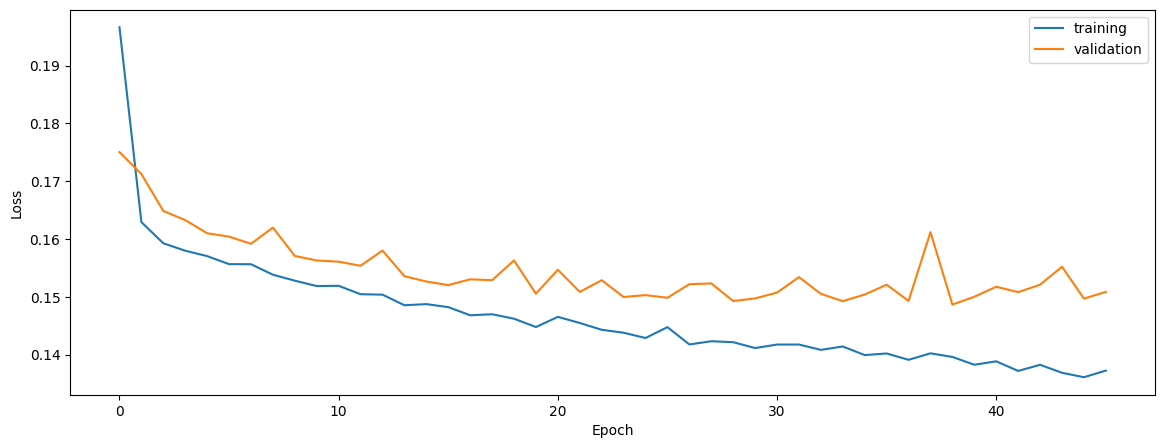

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.6698339417728469
0.6406342775313472
0.6322247568735743


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6621894786080623
0.6462450592885376
0.6281142394166498


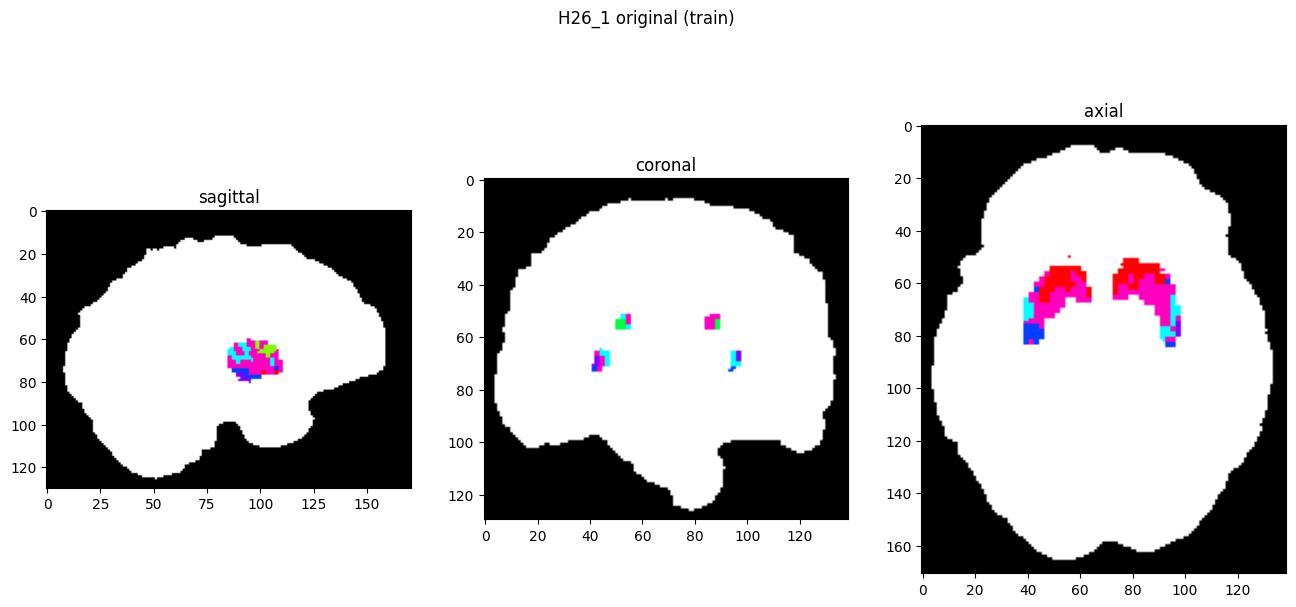

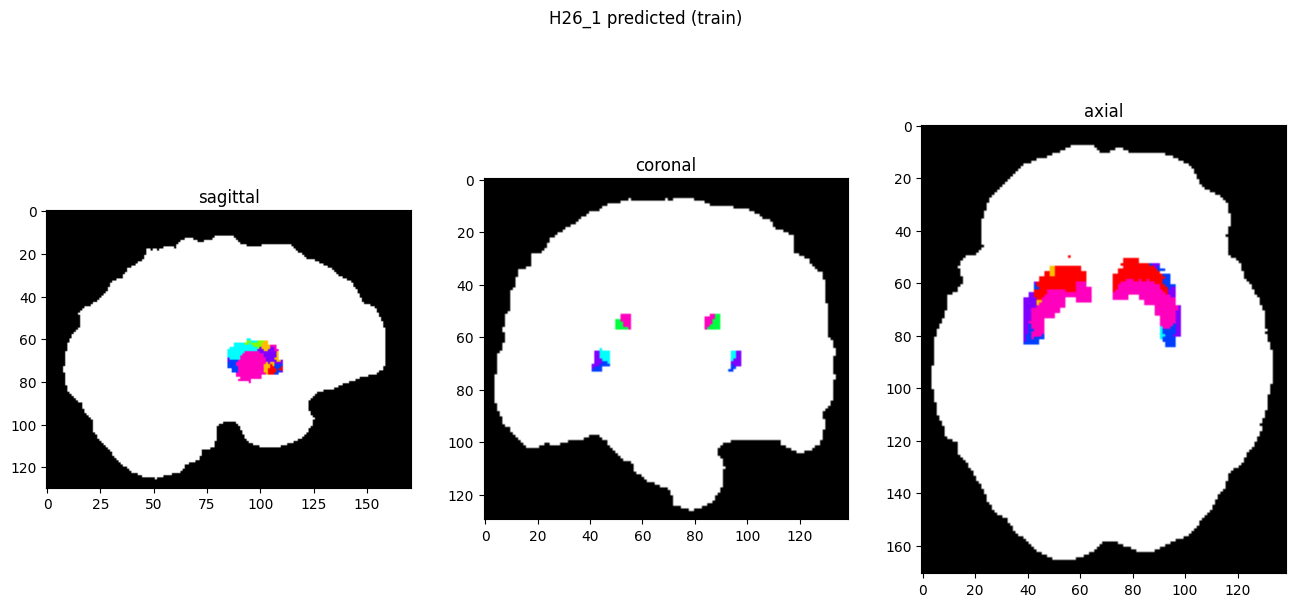

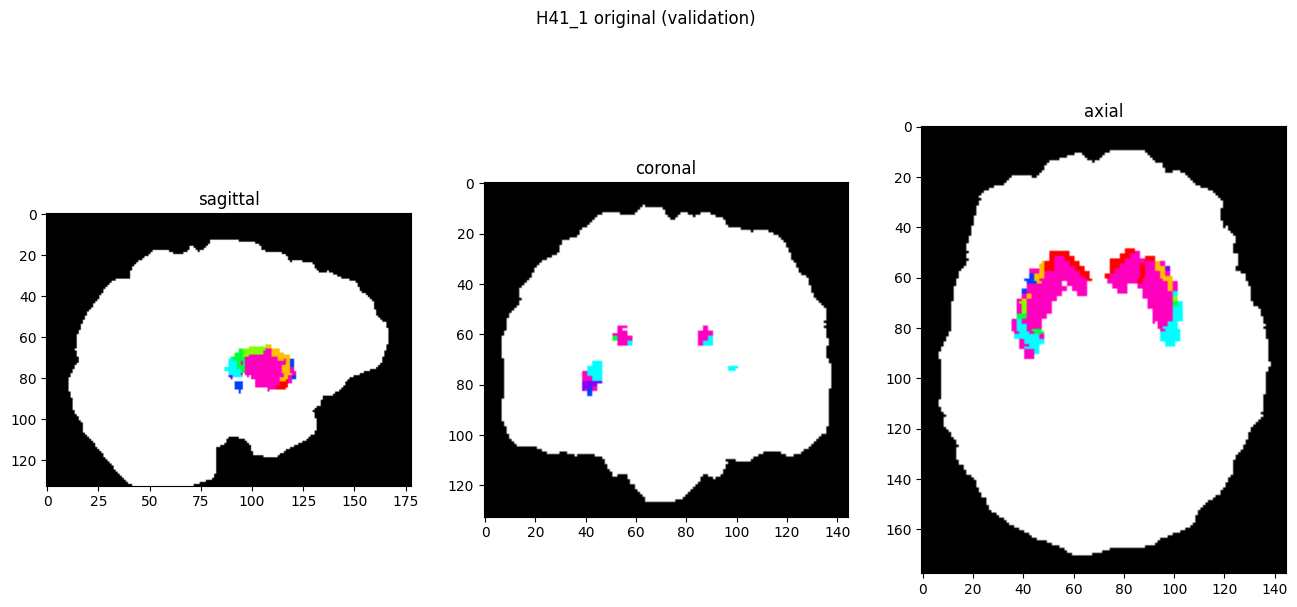

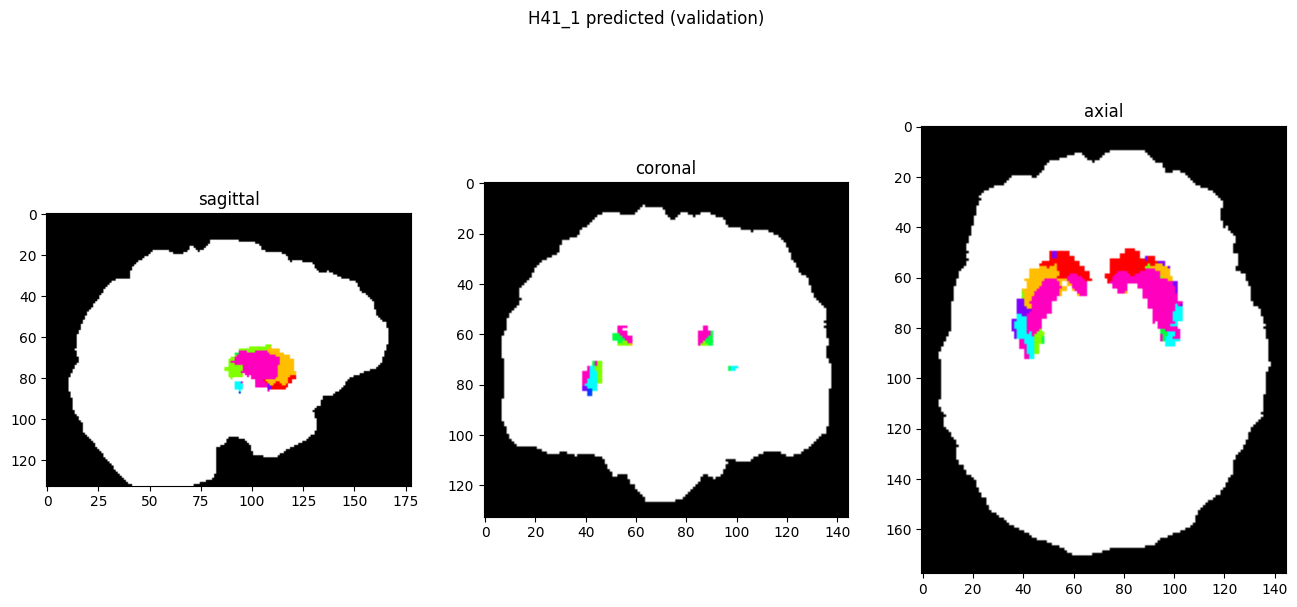

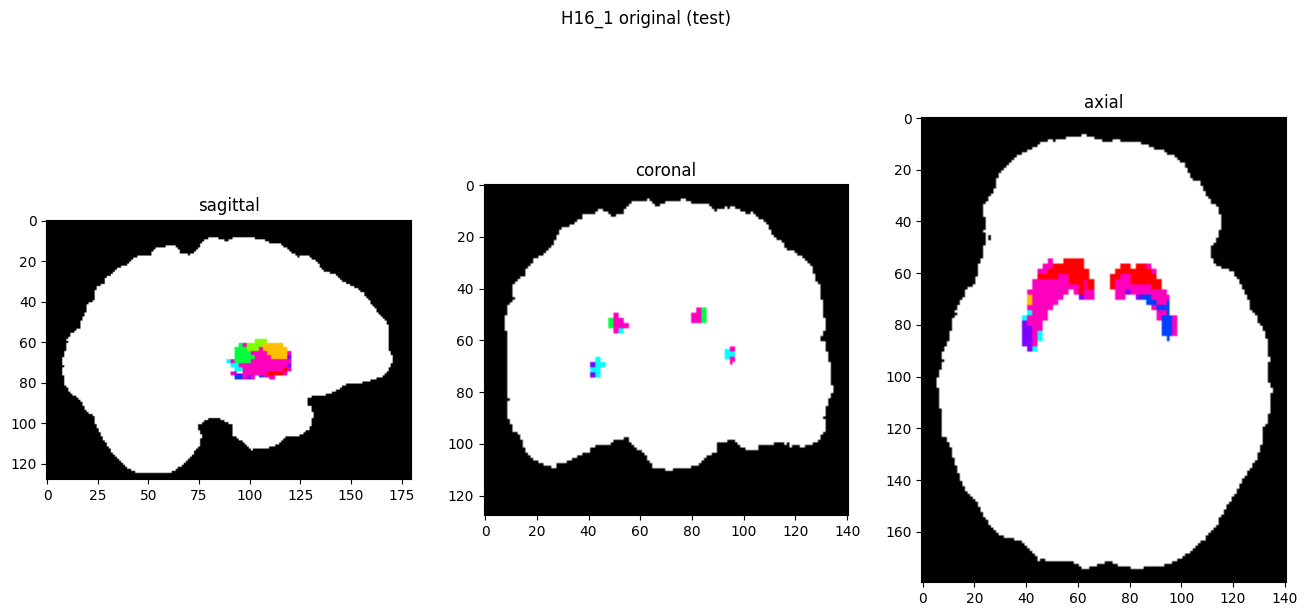

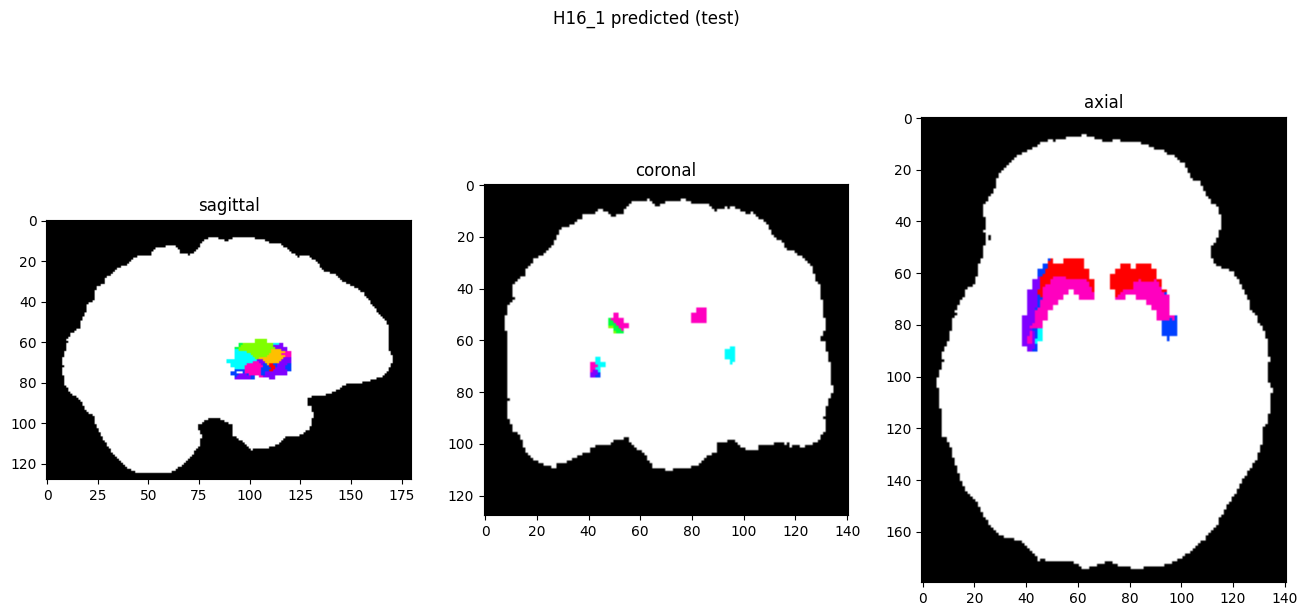

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)